# Replicating the Methodology of "Common Risk Factors in Cryptocurrency": A Python Approach

This file requires the libraries `pandas`, `numpy`, `wand`, `pdf2image`, `Pillow`, `os`, `matplotlib`, `statsmodels`, `pycoingecko`, `warnings`, `requests`, and `json` to run. If one of these imports fails, please install the corresponding library and make sure that you have activated the corresponding virtual environment. In addition, make sure to insert your Federal Reserve Bank of St. Louis API key in the `"fred_data"` file. You may need additional API keys if you want to make use of the additional data sources.

The project follows closely the methodology proposed by Liu, Tsyvinski, and Wu (2022) in their paper titled [Common Risk Factors in Cryptocurrency](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13119). Researchers and practitioners can use this paper to approximate the results of the paper and perhaps retrieve an updated version of the basic findings. They can also use it as a tool kit to use for other projects or to run an extended analysis including further risk factors. For this purpose, I have also added various additional variables in the folder `"data_retrieval"`, that can be included in extended analyses.

In this analysis, I occasionally had to make assumption, for example, regarding the process to convert the sample frequency. This is especially so because the authors of the paper did not provide a detailed description. There are other, perhaps better ways of performing certain steps and I am always grateful for any feedback that you might provide. I explicitly made comments to explain my assumptions.

The order of the following sections matches the structure of the original paper. The outline is:
* <a href="#I._Data">I. Data</a>
* <a href="#II._Cross-Sectional_Return_Predictor">II. Cross-Sectional Return Predictors</a>
    * <a href="#A._Size_Characteristics">A. Size Characteristics</a>
    * <a href="#B._Momentum_Characteristics">B. Momentum Characteristics</a>
    * <a href="#C._Volume_Characteristics">C. Volume Characteristics</a>
    * <a href="#D._Volatility_Characteristics">D. Volatility Characteristics</a>
* <a href="#III._Cryptoccurency_Factors">III. Cryptocurrency Factors</a>

This Jupyter Notebook is accompanied by my master's thesis that serves as a comprehensive read-me.

<a id="I._Data"></a> 
# I. Data

The individual data files already exist.
The data was already merged into a single file.
The data has already been converted to weekly frequency.
Count total NaN at each column in a dataframe:

 DGS1MO    758
dtype: int64
The market returns data has already been computed.


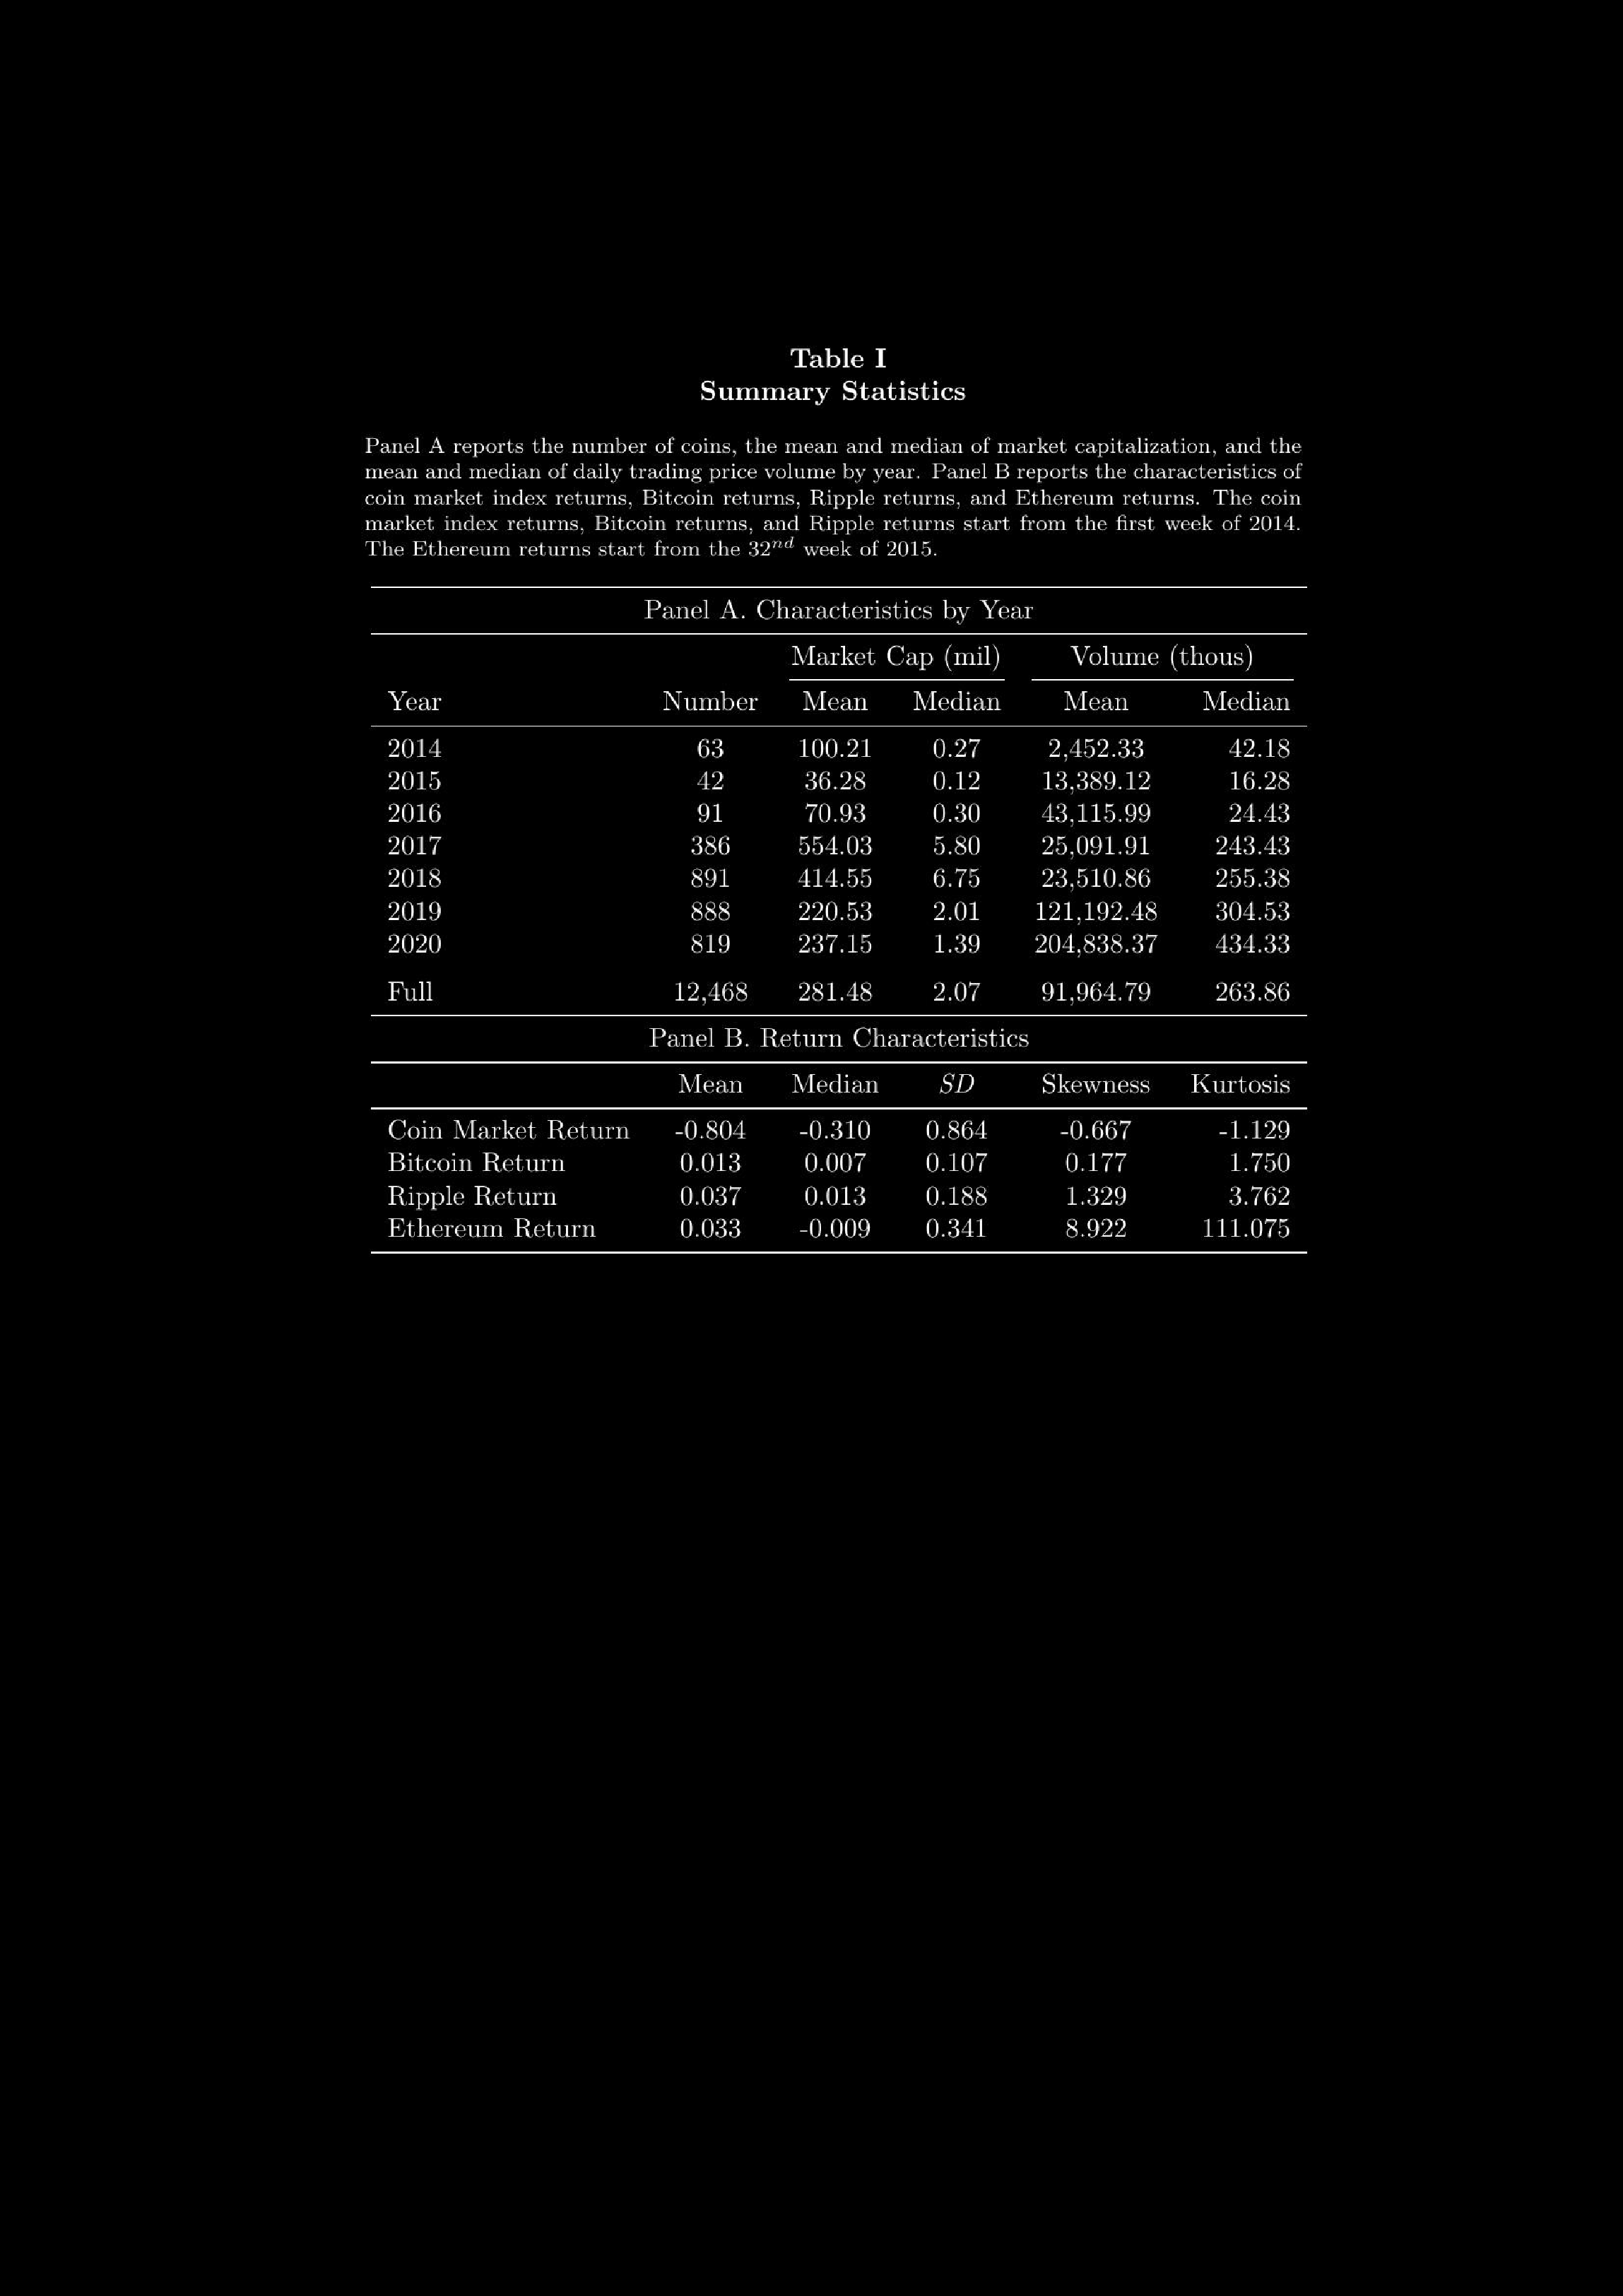

In [1]:
import pandas as pd, numpy as np, os, data_retrieval.coingecko_data as coingecko_data, helpers, data_retrieval.fred_data as fred_data, warnings
pd.options.mode.chained_assignment = None
from wand.image import Image

# there should not be any warning messages in the current state of the file in any case
if input("Do you want to disable all warning messages? y/n ") in ["Y", "y"]:
    disable_warnings = True
else:
    disable_warnings = False

if disable_warnings:
    warnings.simplefilter("ignore")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# specify the data range for the analysis
# in the paper, the authors start on 2014-01-01 due to data availability
start_date = pd.to_datetime("2014-01-01")
end_date = pd.to_datetime("2020-07-31")
# this is the time frame used in the original paper
# use this if you want to run the analysis up until today
# end_date = pd.to_datetime("today")

# select the path to the directory where you want to store the data
directory = os.getcwd() + "/data"

# downloading the data from CoinGecko.com and storing it in smaller data subsets at the specified location
# the data contains daily prices, market caps, and trading volumes
# this step can take up to 2 days due to the API traffic limit
# we are also always checking if the subsequent files already exist (/cg_data.csv, /cg_weekly_data.csv, /cg_weekly_returns.csv, /market_weekly_returns.csv)
# this helps in case the previous files have been deleted
files = ["/coingecko", "/cg_data.csv", "/cg_weekly_returns_data.csv", "/market_weekly_returns.csv"]
if any(os.path.exists(directory + file) for file in files):
    # if at least 1 file already exists
    print("The individual data files already exist.")
else:
    # if the file or the subsequent files do not already exist
    coingecko_data.retrieve_data(start_date, end_date, path=directory)

# merging the data subsets and storing the result at the specified location
if any(os.path.exists(directory + file) for file in files[1:]):
    # if at least 1 file already exists
    print("The data was already merged into a single file.")  
else:
    # if the file or the subsequent files do not already exist
    helpers.merge_data(path=directory)  

daily_trading_data = pd.read_csv(directory + "/cg_data.csv", index_col=["date"])
daily_trading_data.index = pd.to_datetime(daily_trading_data.index)
# making sure the subdataframe for every coin_id has the same length
# when the time frame set above is shorter than the date range in the retrieved data set, the data set is truncated
date_range = pd.date_range(start=start_date, end=end_date, freq="D")
daily_trading_data = daily_trading_data.groupby("coin_id", group_keys=True).apply(lambda x: x.reindex(date_range)).reset_index(level="coin_id", drop=True)
# making sure the previously missing values have a value for coin_id
daily_trading_data["coin_id"].fillna(method="ffill", inplace=True)

# downloading the data since the conversion process might also take a long time
if any(os.path.exists(directory + file) for file in files[2:]):
    # if at least 1 file already exists
    print("The data has already been converted to weekly frequency.")
    weekly_returns_data = pd.read_csv(directory + "/cg_weekly_returns_data.csv", index_col=["date"])
    weekly_returns_data.index = pd.to_datetime(weekly_returns_data.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    weekly_returns_data = weekly_returns_data.groupby("coin_id", group_keys=False).apply(lambda x: x.reindex(date_range))
else:
    # this function converts the frequency and also computes the return series
    # this step can take a while
    weekly_returns_data = helpers.convert_frequency(daily_trading_data, method="last", returns=True)
    # imputing all missing return values by the mean after the first non-missing value
    weekly_returns_data["return"] = weekly_returns_data.groupby("coin_id", group_keys=False)["return"].transform(lambda x: x.loc[x.first_valid_index():].fillna(x.mean()))
    # imputing all missing market_cap values by the average of the last and next available data values after the first non-missing value
    weekly_returns_data["market_cap"] = weekly_returns_data.groupby("coin_id", group_keys=False)["market_cap"].transform(lambda x: x.loc[x.first_valid_index():].fillna((x.fillna(method="backfill") + x.fillna(method="ffill")) / 2))
    # some returns are exorbitant (above 10,00%) and need to be removed
    weekly_returns_data["return"].where(weekly_returns_data["return"] < 10, np.nan, inplace=True)
    # including only cryptocurrencies with a market capitalization above $1 million on a given date; also exclude the rows where the market capitalization is missing
    for var in ["price", "return", "total_volume"]:
        weekly_returns_data.loc[((weekly_returns_data["market_cap"].isna()) | (weekly_returns_data["market_cap"] < 1000000)) & ~weekly_returns_data["coin_id"].isin(["bitcoin", "ripple", "ethereum"]), var] = np.nan
    # downloading the data
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    weekly_returns_data = weekly_returns_data.groupby("coin_id", group_keys=False).apply(lambda x: x.reindex(date_range))
    weekly_returns_data["coin_id"].fillna(method="ffill", inplace=True)
    weekly_returns_data.to_csv(directory + "/cg_weekly_returns_data.csv")

# imputing all missing market_cap values by the average of the last and next available data values after the first non-missing value
daily_trading_data["market_cap"] = daily_trading_data.groupby("coin_id", group_keys=False)["market_cap"].transform(lambda x: x.loc[x.first_valid_index():].fillna((x.fillna(method="backfill") + x.fillna(method="ffill")) / 2))
# including only cryptocurrencies with a market capitalization above $1 million on a given date; also exclude the rows where the market capitalization is missing
daily_trading_data.loc[((daily_trading_data["market_cap"].isna()) | (daily_trading_data["market_cap"] < 1000000)) & ~daily_trading_data["coin_id"].isin(["bitcoin", "ripple", "ethereum"]), "price"] = np.nan
daily_trading_data.loc[((daily_trading_data["market_cap"].isna()) | (daily_trading_data["market_cap"] < 1000000)) & ~daily_trading_data["coin_id"].isin(["bitcoin", "ripple", "ethereum"]), "total_volume"] = np.nan

# computing the risk-free rate
# a pd dataframe with columns for date and DGS1MO
risk_free_rate_daily_data = fred_data.retrieve_data(start_date, end_date, series_ids = ["DGS1MO"], download=False)
# converting to weekly data before making changes to risk_free_rate_daily_data
date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
risk_free_rate = risk_free_rate_daily_data.resample("W-SUN").last().reindex(date_range)
# the missing data points mostly lie on weekends, and hence we impute these values by the average of the Friday and Monday values
# computing the average of the Friday and Monday values
risk_free_rate_daily_data["monday_shifted_to_friday"] = risk_free_rate_daily_data["DGS1MO"].shift(-3)
risk_free_rate_daily_data["monday_friday_average"] = (risk_free_rate_daily_data["DGS1MO"] + risk_free_rate_daily_data["monday_shifted_to_friday"]) / 2
# shifting the results from Friday to Saturday
risk_free_rate_daily_data["monday_friday_average_saturday"] = risk_free_rate_daily_data["monday_friday_average"].shift(1)
# and to Sunday
risk_free_rate_daily_data["monday_friday_average_sunday"] = risk_free_rate_daily_data["monday_friday_average"].shift(2)
risk_free_rate_daily_data.loc[risk_free_rate_daily_data.index.weekday == 5, "DGS1MO"] = risk_free_rate_daily_data["monday_friday_average_saturday"]
risk_free_rate_daily_data.loc[risk_free_rate_daily_data.index.weekday == 6, "DGS1MO"] = risk_free_rate_daily_data["monday_friday_average_sunday"]
# next, we impute all remaining missing data points by the average of the last and next available data values
risk_free_rate_daily_data["DGS1MO"] = (risk_free_rate_daily_data["DGS1MO"].fillna(method="backfill") + risk_free_rate_daily_data["DGS1MO"].fillna(method="ffill")) / 2
# also making sure the last and first values are set properly in case they are missing
risk_free_rate_daily_data["DGS1MO"] = risk_free_rate_daily_data["DGS1MO"].fillna(method="backfill").fillna(method="ffill")

# downloading the data since the returns computation process might also take long
if any(os.path.exists(directory + file) for file in files[3:]):
    # if at least 1 file already exists
    print("The market returns data has already been computed.")
    market_weekly_returns = pd.read_csv(directory + "/market_weekly_returns.csv", index_col=["date"])
    market_weekly_returns.index = pd.to_datetime(market_weekly_returns.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    market_weekly_returns = market_weekly_returns.reindex(date_range)
else:
    # compute the excess weighted average of the returns using the market capitalization as the weight
    market_weekly_returns = weekly_returns_data.groupby(weekly_returns_data.index, group_keys=False).apply(lambda x: (x["return"]*x["market_cap"]).sum()/x["market_cap"].sum())
    market_weekly_returns.rename("market_return", inplace=True)
    market_weekly_returns = market_weekly_returns.to_frame()
    market_weekly_returns.index = pd.to_datetime(market_weekly_returns.index)
    # imputing all missing values with the mean after the first non-missing value
    market_weekly_returns["market_return"] = market_weekly_returns["market_return"].loc[market_weekly_returns["market_return"].first_valid_index():].fillna(market_weekly_returns["market_return"].mean())
    # making sure the first return value is missing and not 0
    market_weekly_returns.loc[market_weekly_returns.index == market_weekly_returns.index.min(), "market_return"] = np.nan
    # filling the missing values with NaNs
    date_range = pd.date_range(start=start_date, end=end_date, freq="W")
    market_weekly_returns = market_weekly_returns.reindex(date_range)
    market_weekly_returns.index.name = "date"
    market_weekly_returns["market_excess_return"] = market_weekly_returns["market_return"].sub(risk_free_rate["DGS1MO"], axis=0)
    # downloading the data
    market_weekly_returns.to_csv(directory + "/market_weekly_returns.csv")

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file
helpers.render_summary_statistics(daily_data=daily_trading_data, market_weekly_data=market_weekly_returns, weekly_data=weekly_returns_data, invert=invert)

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

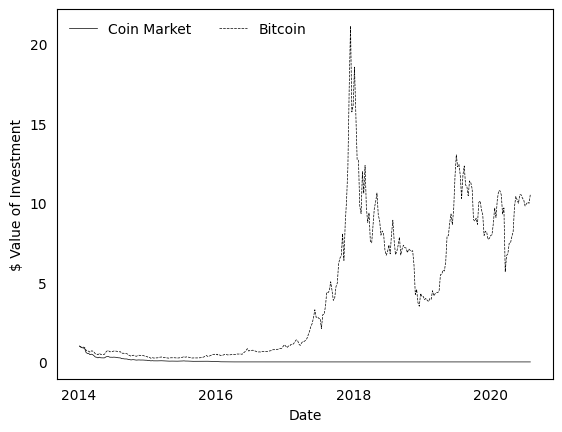

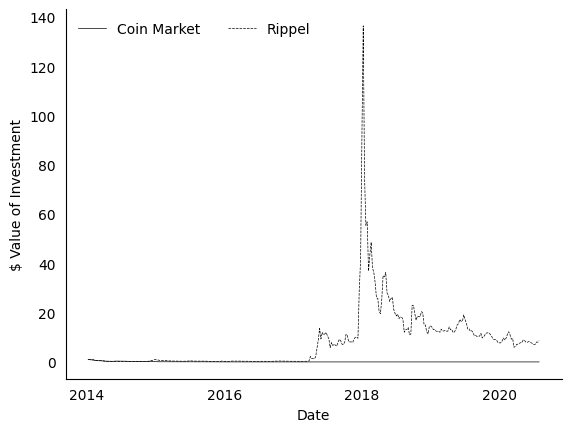

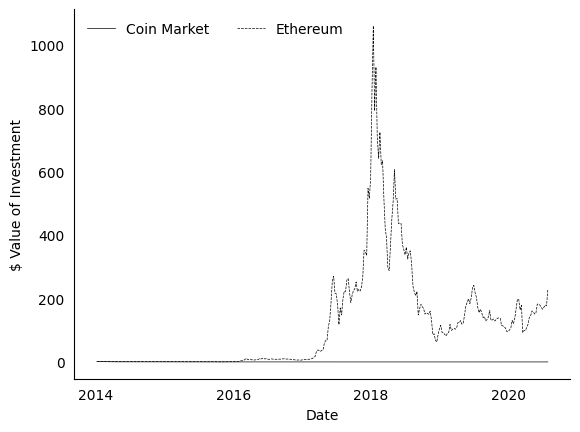

Figure 1. Cryptocurrency market and major coins. This figure plots the aggregate cryptocurrency market against Bitcoin, Ripple, and Ethereum.


In [2]:
pd.options.mode.chained_assignment = None
if disable_warnings:
    warnings.simplefilter("ignore")

# plotting the time series graphs
import matplotlib.pyplot as plt, numpy as np

bitcoin_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "bitcoin"]
ripple_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "ripple"]
ethereum_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "ethereum"]

year_and_week = (market_weekly_returns.index.isocalendar().year + market_weekly_returns.index.isocalendar().week / 52).tolist()

market_weekly_returns["market_index"] = (1 + market_weekly_returns["market_excess_return"]).cumprod()
# setting the first value of return_index to 1
market_weekly_returns.loc[market_weekly_returns.index == market_weekly_returns.index.min(), "market_index"] = 1
# imputing missing index values with the last non-missing value
market_weekly_returns["market_index"] = market_weekly_returns["market_index"].fillna(method='ffill')
market_index = market_weekly_returns["market_index"].tolist()

bitcoin_weekly_returns["bitcoin_index"] = (1 + bitcoin_weekly_returns["return"]).cumprod()
bitcoin_weekly_returns.loc[bitcoin_weekly_returns.index == bitcoin_weekly_returns.index.min(), "bitcoin_index"] = 1
bitcoin_weekly_returns["bitcoin_index"] = bitcoin_weekly_returns["bitcoin_index"].fillna(method='ffill')
bitcoin_index = bitcoin_weekly_returns["bitcoin_index"].tolist()

ripple_weekly_returns["ripple_index"] = (1 + ripple_weekly_returns["return"]).cumprod()
ripple_weekly_returns.loc[ripple_weekly_returns.index == ripple_weekly_returns.index.min(), "ripple_index"] = 1
ripple_weekly_returns["ripple_index"] = ripple_weekly_returns["ripple_index"].fillna(method='ffill')
ripple_index = ripple_weekly_returns["ripple_index"].tolist()

ethereum_weekly_returns["ethereum_index"] = (1 + ethereum_weekly_returns["return"]).cumprod()
ethereum_weekly_returns.loc[ethereum_weekly_returns.index == ethereum_weekly_returns.index.min(), "ethereum_index"] = 1
ethereum_weekly_returns["ethereum_index"] = ethereum_weekly_returns["ethereum_index"].fillna(method='ffill')
ethereum_index = ethereum_weekly_returns["ethereum_index"].tolist()

vars = [bitcoin_index, ripple_index, ethereum_index]
labels = ["Bitcoin", "Rippel", "Ethereum"]
max = [10000, 10000, 10000]
step_size = [10, 50, 100]

for i in range(3):
    plt.plot(year_and_week, np.array(market_index), color="black", label="Coin Market", linewidth=0.5)
    plt.plot(year_and_week, np.array(vars[i]), color="black", linestyle="dashed", label = labels[i], linewidth=0.5)
    plt.tick_params(color="white")
    plt.xticks(np.arange(start_date.year, end_date.year + 1, 2))
    plt.xlabel("Date")
    plt.ylabel("$ Value of Investment")
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.legend(frameon=False, prop={"size": 10}, loc="upper left", ncol=2)
    plt.show()
print("Figure 1. Cryptocurrency market and major coins. This figure plots the aggregate cryptocurrency market against Bitcoin, Ripple, and Ethereum.")

<a id="II._Cross-Sectional_Return_Predictor"></a>
# II. Cross-Sectional Return Predictor

<a id="A._Size_Characteristics"></a>
## A. Size Characteristics

The data for the excess long-short strategies for the different size characteristics has already been computed.
Table 2 lists the return predictor definitions and can be found in the paper.


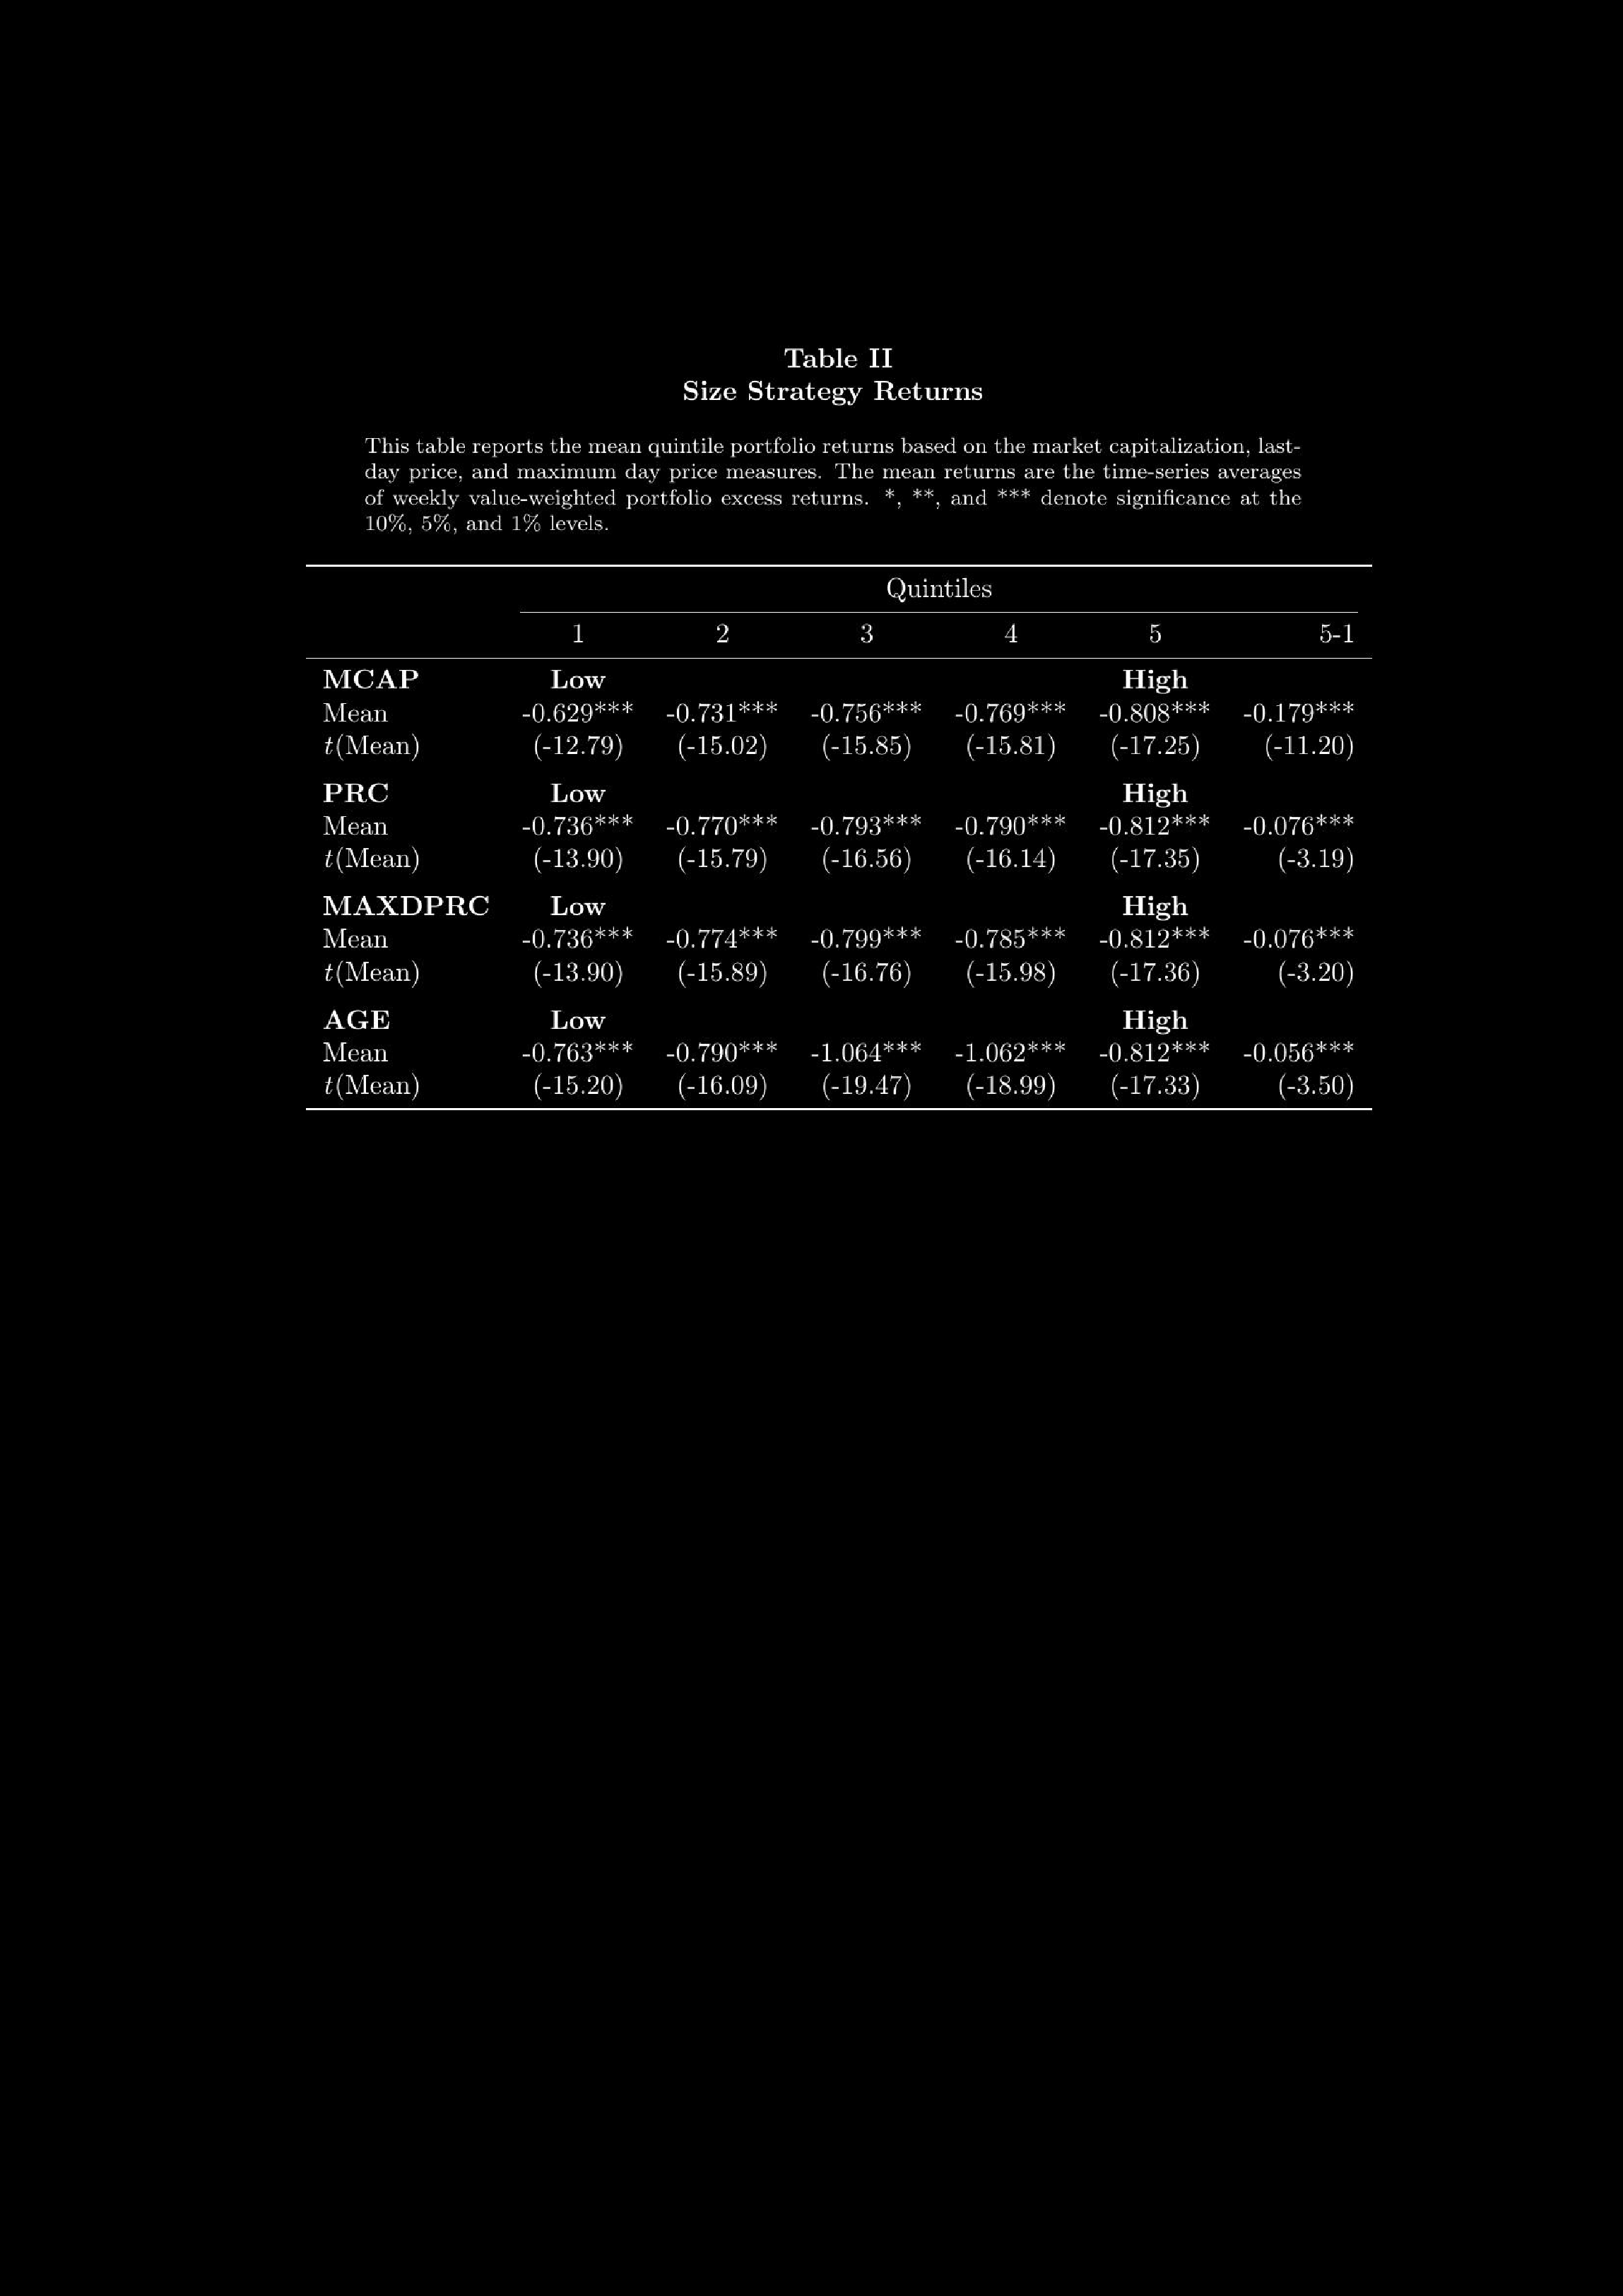

In [3]:
pd.options.mode.chained_assignment = None
if disable_warnings:
    warnings.simplefilter("ignore")

# this steps might take a little longer, so it makes sense to save the data
if not os.path.exists(directory + "/weekly_returns_size_data.csv"):
    # creating the data for the size characteristics in coins_weekly_returns
    # adding log_market_cap
    weekly_returns_data["log_market_cap"] = np.where(weekly_returns_data["market_cap"] == 0, np.nan, np.log(weekly_returns_data["market_cap"]))
    # adding log_price
    weekly_returns_data["log_price"] = np.where(weekly_returns_data["price"] == 0, np.nan, np.log(weekly_returns_data["price"]))
    # adding log_max_price
    # this step might take a while
    max_price = helpers.convert_frequency(daily_trading_data[["coin_id", "price"]], method="max")["price"]
    weekly_returns_data["log_max_price"] = np.where(max_price == 0, np.nan, np.log(max_price))
    # adding age as the number of days listed since the first trading day of that respective coin (considering that the time period begins on 2014-01-01)
    weekly_returns_data["age"] = weekly_returns_data.groupby("coin_id", group_keys=False)["return"].transform(lambda x: np.maximum(0, (x.index - x.first_valid_index()).days) if x.first_valid_index() is not None else pd.Series([0] * len(x)))
    # making sure no dates were lost
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    weekly_returns_data = weekly_returns_data.groupby("coin_id", group_keys=False).apply(lambda x: x.reindex(date_range))
    weekly_returns_data.to_csv(directory + "/weekly_returns_size_data.csv")
else:
    weekly_returns_data = pd.read_csv(directory + "/weekly_returns_size_data.csv", index_col=["date"])
    weekly_returns_data.index = pd.to_datetime(weekly_returns_data.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    weekly_returns_data = weekly_returns_data.groupby("coin_id", group_keys=False).apply(lambda x: x.reindex(date_range))
# computing the zero-investment long-short strategies based on the size-related characteristics of market capitalization, price, maximum day price, and age
if not os.path.exists(directory + "/quintile_size_data.csv"):
    quintile_data = risk_free_rate
    for size_characteristic in ["log_market_cap", "log_price", "log_max_price", "age"]:
        quintile_returns_data = helpers.quintile_returns(weekly_returns_data, size_characteristic)
        # subtracting the risk-free rate from every column of quintile returns
        quintile_returns_data = quintile_returns_data.sub(quintile_data["DGS1MO"], axis=0)
        quintile_data = pd.concat([quintile_data, quintile_returns_data], axis=1)
        # computing the returns of the long-short strategy
        quintile_data[size_characteristic + "_long_short"] = np.where(quintile_data[size_characteristic + "_q1"].isna(), quintile_data[size_characteristic + "_q5"], quintile_data[size_characteristic + "_q5"] - quintile_data[size_characteristic + "_q1"])

    quintile_data.index.name = "date"
    # downloading the data
    quintile_data.to_csv(directory + "/quintile_size_data.csv")
else:
    print("The data for the excess long-short strategies for the different size characteristics has already been computed.")
    quintile_data = pd.read_csv(directory + "/quintile_size_data.csv", index_col=["date"])
    quintile_data.index = pd.to_datetime(quintile_data.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    quintile_data = quintile_data.reindex(date_range)

print("Table 2 lists the return predictor definitions and can be found in the paper.")

# use "\symbol{37}" in the latex file for the percentage sign
helpers.render_quintiles(quintile_data, "latex_templates/size_quintiles.tex", ["log_market_cap", "log_price", "log_max_price", "age"], invert)

pdf_path = os.getcwd() + "/cover.pdf"
img = Image(filename=pdf_path, resolution=100)
img

<a id="B._Momentum_Characteristics"></a>
## B. Momentum Characteristics

The data for the excess long-short strategies for the different momentum strategies has already been computed.


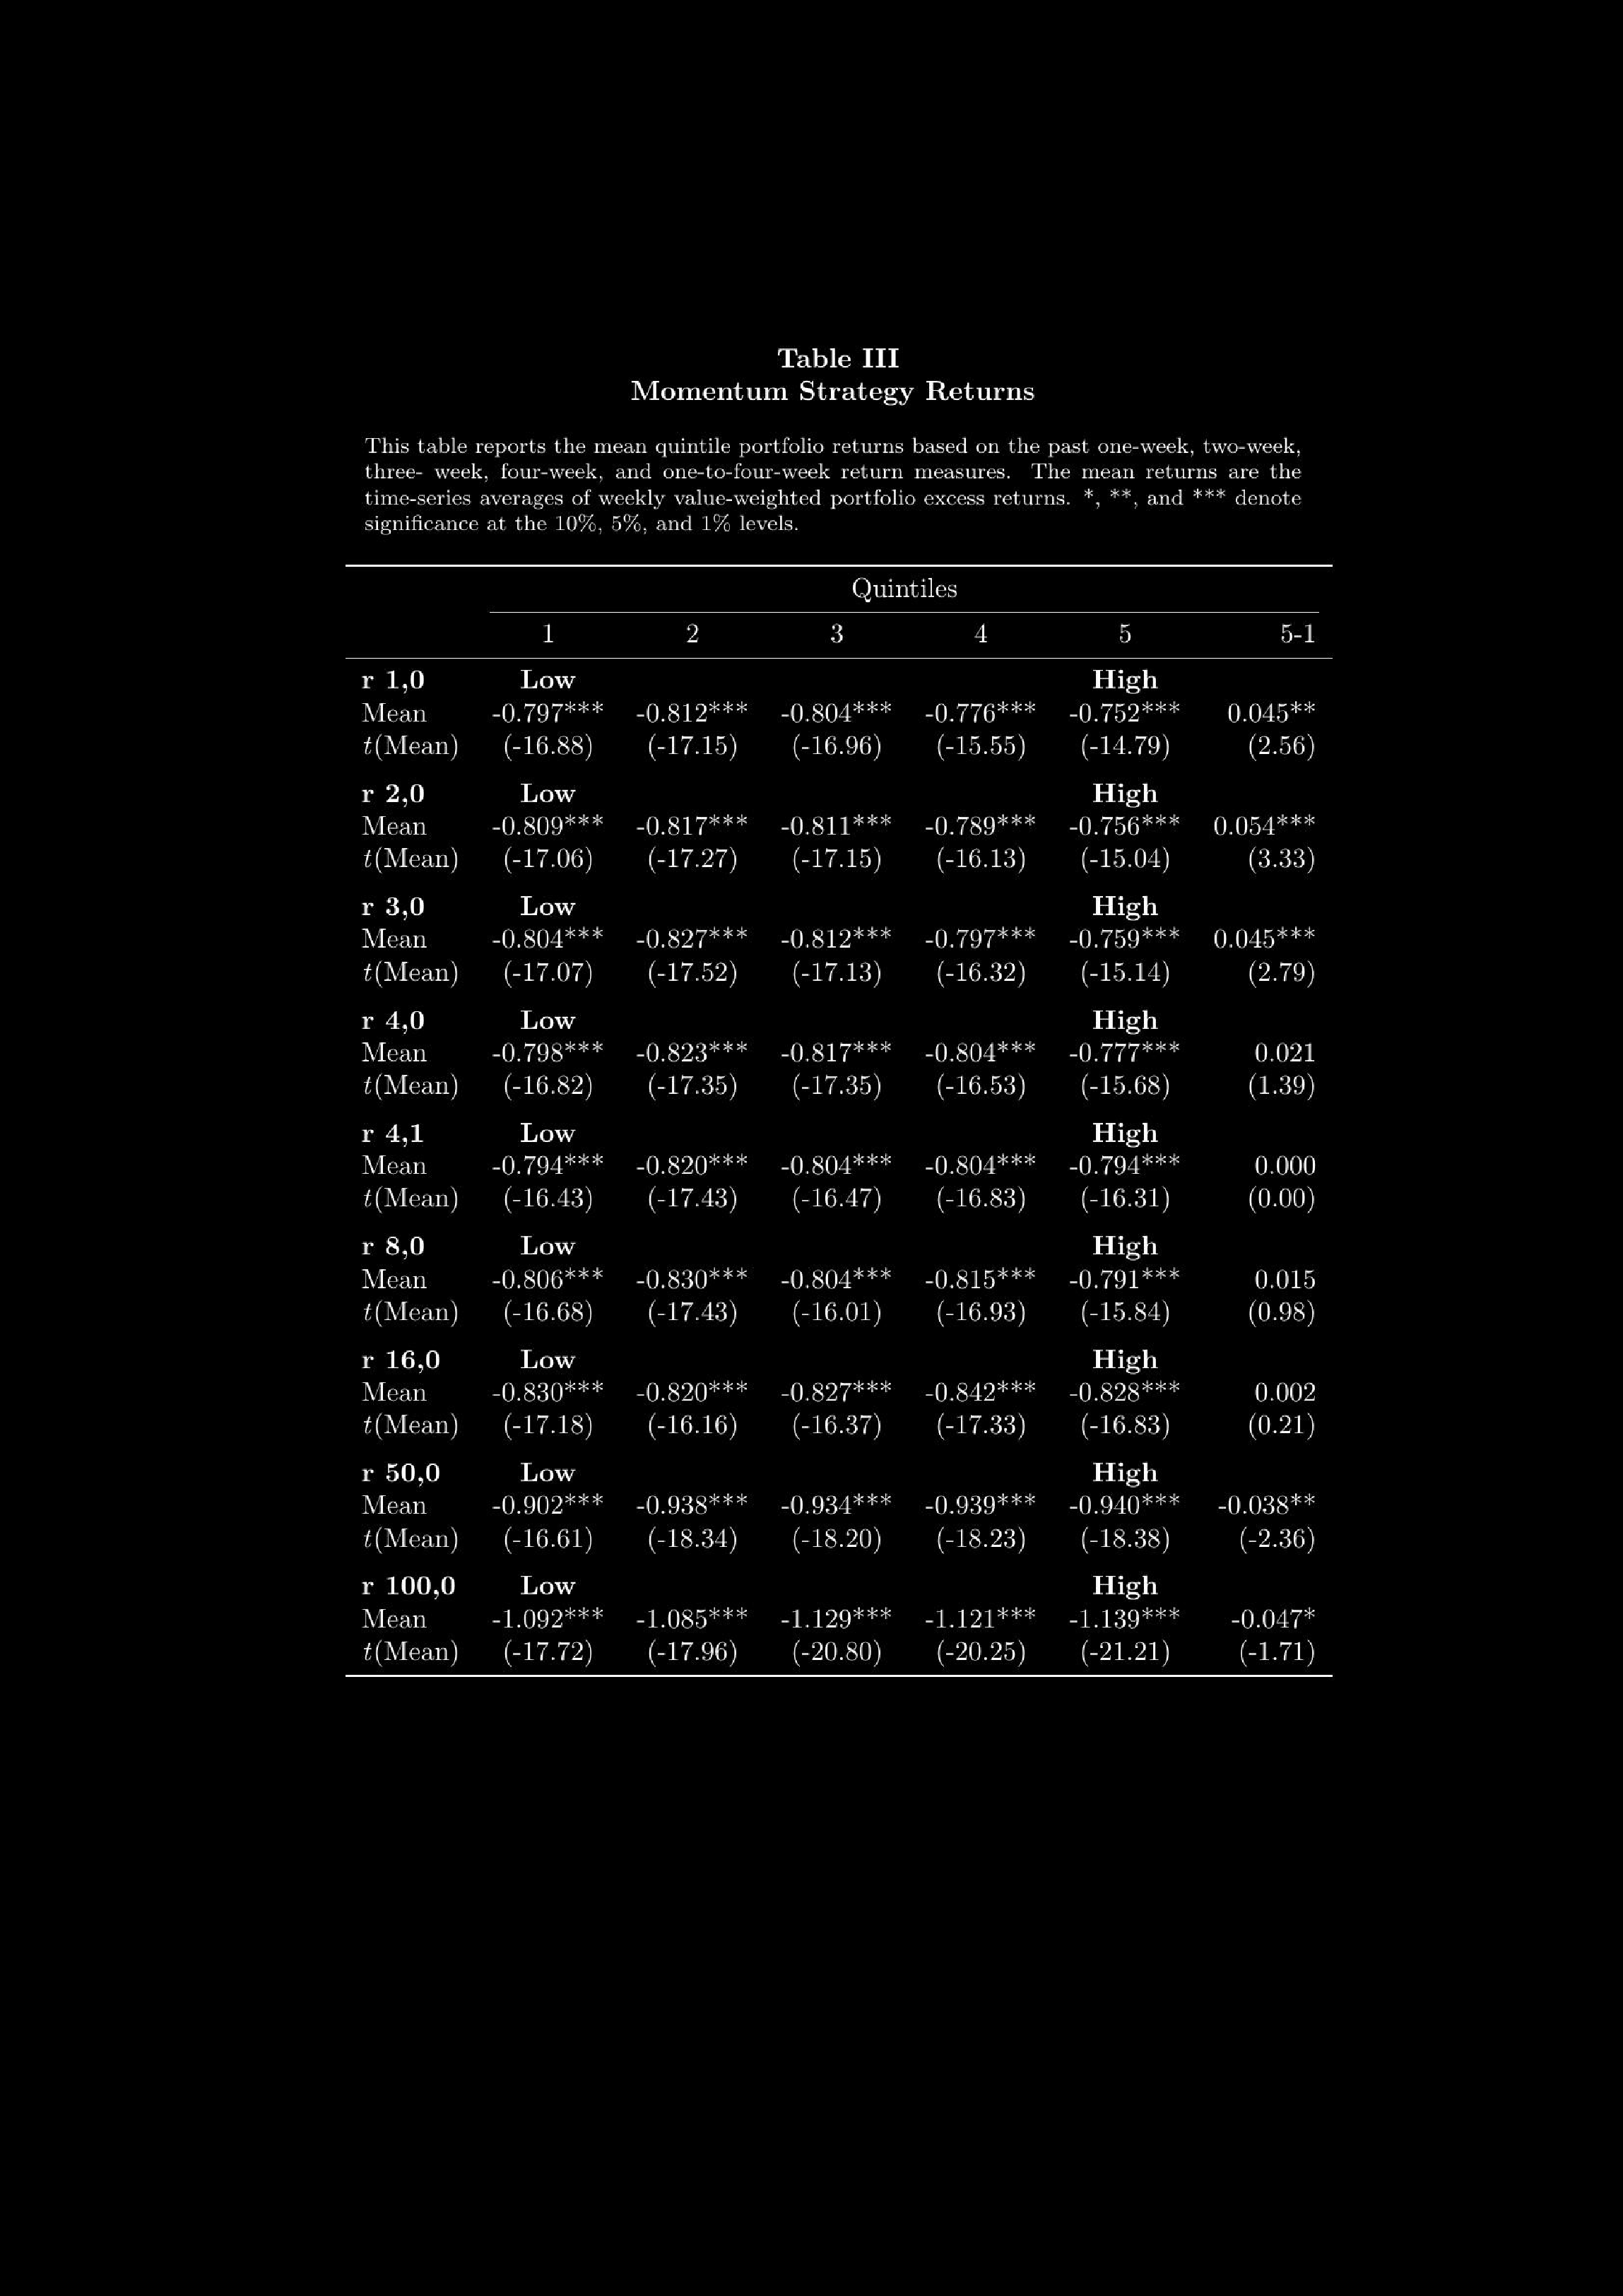

In [4]:
pd.options.mode.chained_assignment = None
if disable_warnings:
    warnings.simplefilter("ignore")

# 1-week past returns
weekly_returns_data["one_week_momentum"] = weekly_returns_data["return"]
# 2-week past returns
# here, the transition from one data set to another is not an issue since the variable is always NaN when the return in the same week is NaN
weekly_returns_data["two_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(2).apply(lambda x: x.prod() - 1, raw=True)
# 3-week past returns
weekly_returns_data["three_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(3).apply(lambda x: x.prod() - 1, raw=True)
# 4-week past returns
weekly_returns_data["four_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(4).apply(lambda x: x.prod() - 1, raw=True)
# 1-to-4-week past returns
# applying the transformation to every coin ID subset separately to avoid complications at the transitions between different coin IDs 
weekly_returns_data["one_to_four_week_momentum"] = weekly_returns_data.groupby("coin_id", group_keys=False)["return"].transform(lambda x: (1 + x).shift(1).rolling(3).apply(lambda x: x.prod() - 1, raw=True))
# 8-week past returns
weekly_returns_data["eight_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(8).apply(lambda x: x.prod() - 1, raw=True)
# 16-week past returns
weekly_returns_data["sixteen_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(16).apply(lambda x: x.prod() - 1, raw=True)
# 50-week past returns
weekly_returns_data["fifty_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(50).apply(lambda x: x.prod() - 1, raw=True)
# 100-week past returns
weekly_returns_data["one_hundred_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(100).apply(lambda x: x.prod() - 1, raw=True)

# constructing the return quintiles for the zero-investment long-short strategies based on past 1-, 2-, 3-, 4-, 1-to-4-, 8-, 16-, 50-, and 8-week returns
# downloading the data since the returns computation process might also take a long time
# if the file for weekly returns data does not already exist
if not os.path.exists(directory + "/quintile_momentum_data.csv"):
    quintile_data = risk_free_rate
    for momentum_return_series in ["one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum"]:
        # here we can use the quintile function for the past returns
        quintile_returns_data = helpers.quintile_returns(weekly_returns_data, momentum_return_series)
        # subtracting the risk-free rate from every column of quintile returns
        quintile_returns_data = quintile_returns_data.sub(quintile_data["DGS1MO"], axis=0)
        quintile_data = pd.concat([quintile_data, quintile_returns_data], axis=1)
        # computing the return of the long-short strategy
        quintile_data[momentum_return_series + "_long_short"] = np.where(quintile_data[momentum_return_series + "_q1"].isna(), quintile_data[momentum_return_series + "_q5"], quintile_data[momentum_return_series + "_q5"] - quintile_data[momentum_return_series + "_q1"])

    quintile_data.index.name = "date"
    # downloading the data
    quintile_data.to_csv(directory + "/quintile_momentum_data.csv")
else:
    print("The data for the excess long-short strategies for the different momentum strategies has already been computed.")
    quintile_data = pd.read_csv(directory + "/quintile_momentum_data.csv", index_col=["date"])
    quintile_data.index = pd.to_datetime(quintile_data.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    quintile_data = quintile_data.reindex(date_range)

helpers.render_quintiles(quintile_data, "latex_templates/momentum_quintiles.tex", ["one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum"], invert)

pdf_path = os.getcwd() + "/cover.pdf"
img = Image(filename=pdf_path, resolution=100)
img

<a id="C._Volume_Characteristics"></a>
## C. Volume Characteristics

The data for the excess long-short strategies for the different size characteristics has already been computed.


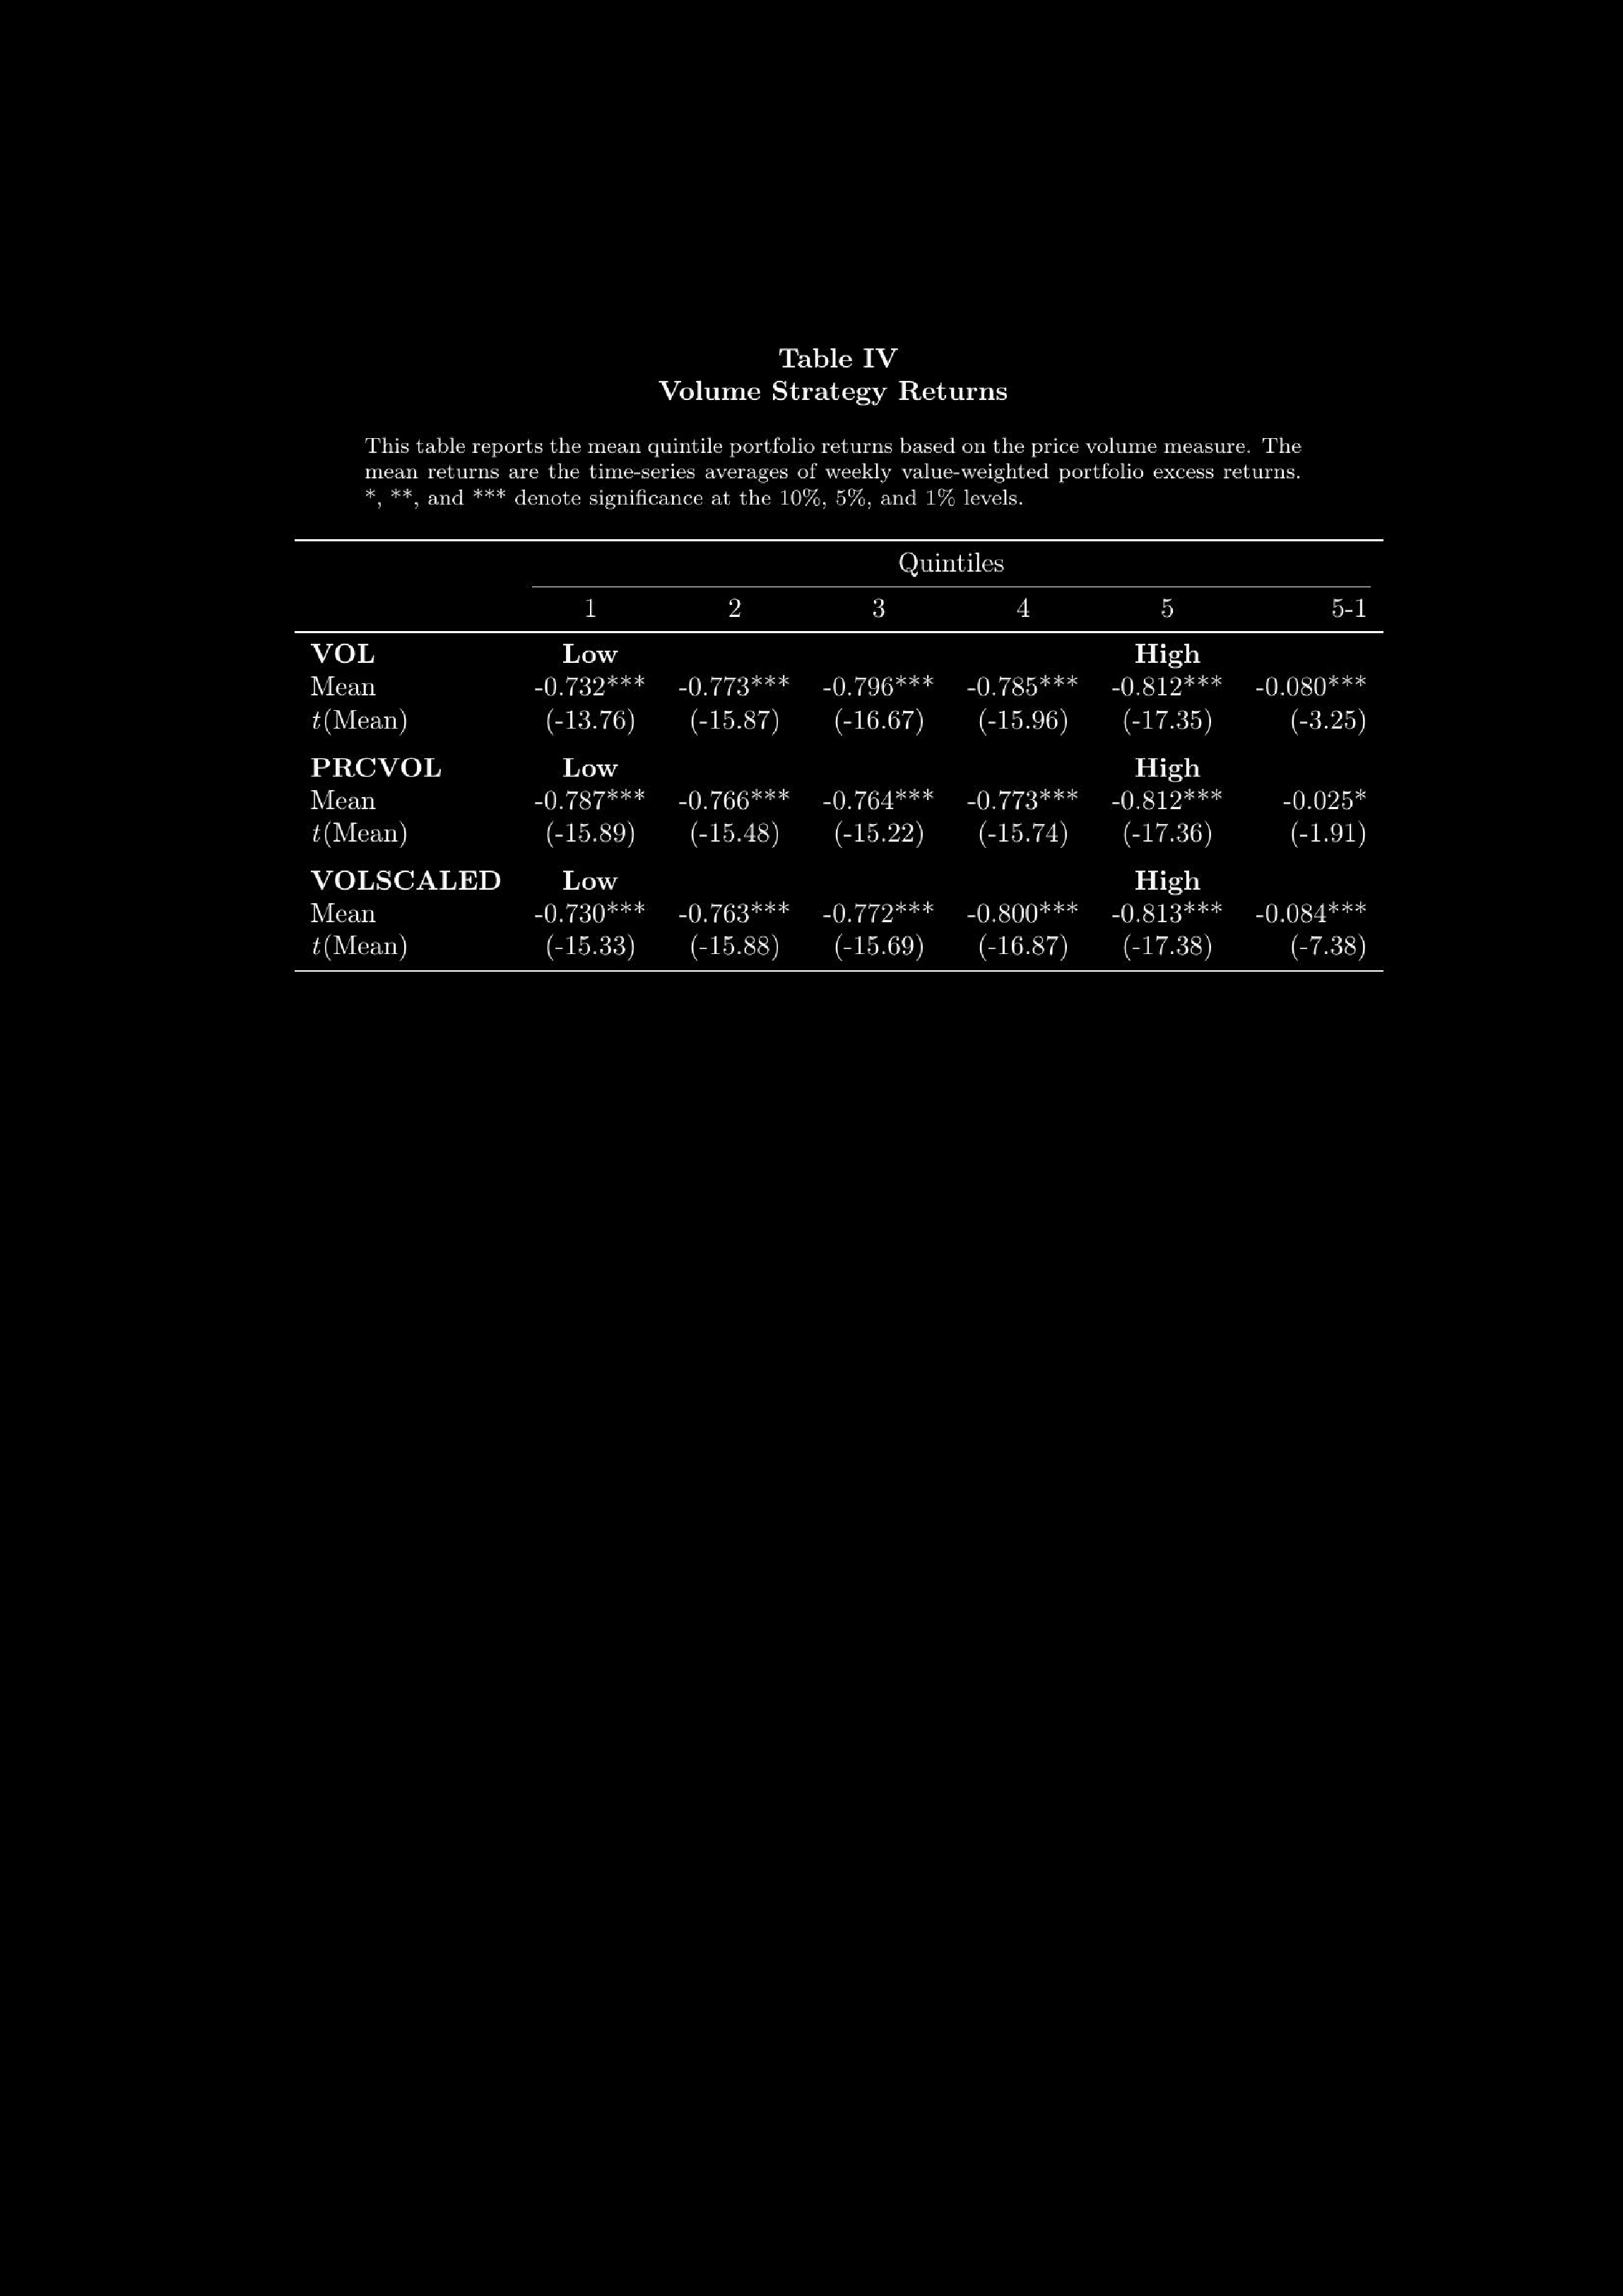

In [5]:
pd.options.mode.chained_assignment = None
if disable_warnings:
    warnings.simplefilter("ignore")

# this steps might take a little longer, so it makes sense to save the data
if not os.path.exists(directory + "/weekly_returns_volume_data.csv"):
    # adding average_volume
    average_volume = helpers.convert_frequency(daily_trading_data[["coin_id", "total_volume"]], method="mean")["total_volume"]
    weekly_returns_data["log_average_volume"] = np.where(average_volume == 0, np.nan, np.log(average_volume))
    # adding price_times_volume
    weekly_returns_data["price_times_volume"] = weekly_returns_data["log_average_volume"] * weekly_returns_data["price"]
    # adding price_times_volume_scaled_market_cap
    weekly_returns_data["price_times_volume_scaled_market_cap"] = weekly_returns_data["price_times_volume"] / weekly_returns_data["market_cap"]
    weekly_returns_data.to_csv(directory + "/weekly_returns_volume_data.csv")
else:
    weekly_returns_data = pd.read_csv(directory + "/weekly_returns_volume_data.csv", index_col=["date"])
    weekly_returns_data.index = pd.to_datetime(weekly_returns_data.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    weekly_returns_data = weekly_returns_data.groupby("coin_id", group_keys=False).apply(lambda x: x.reindex(date_range))

if not os.path.exists(directory + "/quintile_volume_data.csv"):
    quintile_data = risk_free_rate
    for volume_measure in ["log_average_volume", "price_times_volume", "price_times_volume_scaled_market_cap"]:
        # here we can use the quintile function for the past returns
        quintile_returns_data = helpers.quintile_returns(weekly_returns_data, volume_measure)
        # subtracting the risk-free rate from every column of quintile returns
        quintile_returns_data = quintile_returns_data.sub(quintile_data["DGS1MO"], axis=0)
        quintile_data = pd.concat([quintile_data, quintile_returns_data], axis=1)
        # computing the returns of the long-short strategy
        quintile_data[volume_measure + "_long_short"] = np.where(quintile_data[volume_measure + "_q1"].isna(), quintile_data[volume_measure + "_q5"], quintile_data[volume_measure + "_q5"] - quintile_data[volume_measure + "_q1"])
    
    quintile_data.index.name = "date"
    # downloading the data
    quintile_data.to_csv(directory + "/quintile_volume_data.csv")
else:
    print("The data for the excess long-short strategies for the different size characteristics has already been computed.")
    quintile_data = pd.read_csv(directory + "/quintile_volume_data.csv", index_col=["date"])
    quintile_data.index = pd.to_datetime(quintile_data.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    quintile_data = quintile_data.reindex(date_range)

helpers.render_quintiles(quintile_data, "latex_templates/volume_quintiles.tex", ["log_average_volume", "price_times_volume", "price_times_volume_scaled_market_cap"], invert)

pdf_path = os.getcwd() + "/cover.pdf"
img = Image(filename=pdf_path, resolution=100)
img

<a id="D._Volatility_Characteristics"></a>
## D. Volatility Characteristics

The data for the excess long-short strategies for the different volatility strategies has already been computed.


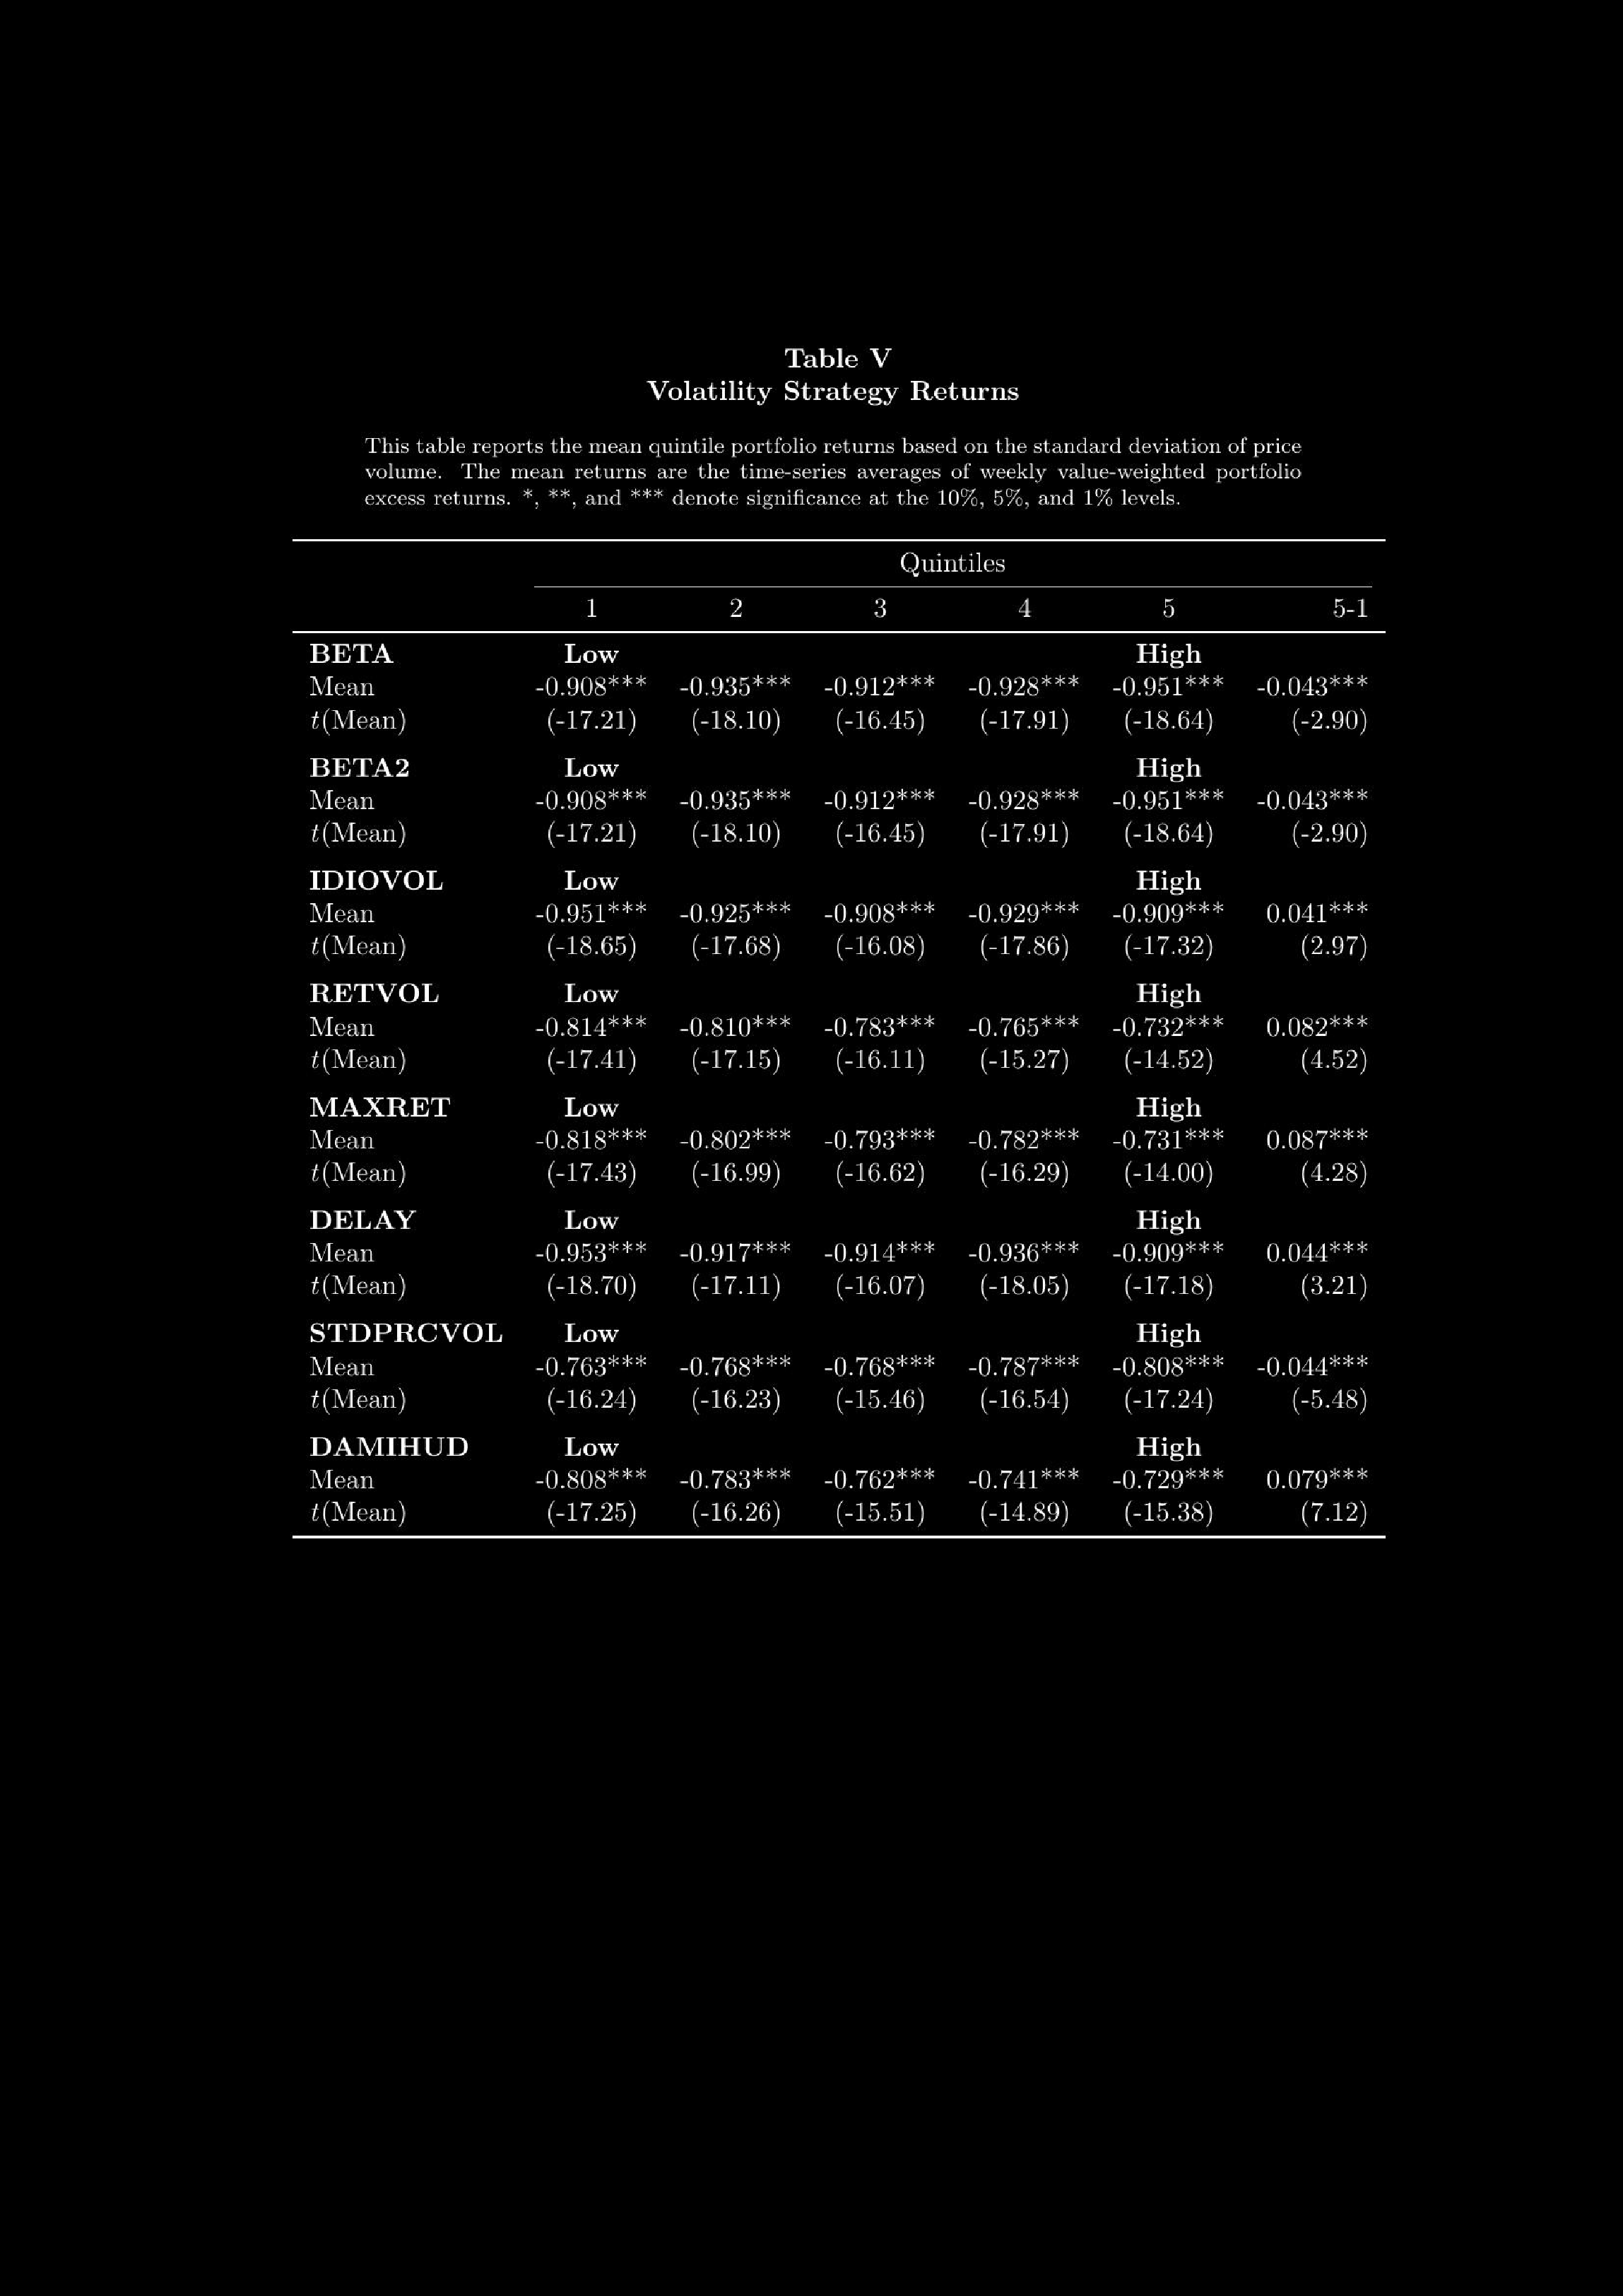

In [6]:
pd.options.mode.chained_assignment = None
if disable_warnings:
    warnings.simplefilter("ignore")

import statsmodels.api as sm
from numpy.lib.stride_tricks import sliding_window_view

# this steps might take a little longer, so it makes sense to save the data
if not os.path.exists(directory + "/weekly_returns_volatility_data.csv"):
    
    # computing the returns of the daily data
    daily_trading_data["return"] = daily_trading_data.groupby("coin_id", group_keys=False)["price"].pct_change()
    # imputing all missing values with the mean after the first non-missing value
    daily_trading_data["return"] = daily_trading_data.groupby("coin_id", group_keys=False)["return"].transform(lambda x: x.loc[x.first_valid_index():].fillna(x.mean()))
    # computing the excess returns of the daily data
    number_unique_coins = daily_trading_data["coin_id"].nunique()
    daily_trading_data = daily_trading_data.assign(risk_free_rate=np.tile(risk_free_rate_daily_data["DGS1MO"].values, number_unique_coins))
    daily_trading_data = daily_trading_data.assign(excess_return=daily_trading_data["return"] - daily_trading_data["risk_free_rate"])
    # computing the daily excess crypto market factor
    market_return = daily_trading_data.groupby(daily_trading_data.index, group_keys=False).apply(lambda x: (x["return"]*x["market_cap"]).sum()/x["market_cap"].sum())
    daily_trading_data = daily_trading_data.assign(market_return=np.tile(market_return.values, number_unique_coins))
    # imputing all missing values with the mean after the first non-missing value
    daily_trading_data["market_return"] = daily_trading_data.groupby("coin_id", group_keys=False)["market_return"].transform(lambda x: x.loc[x.first_valid_index():].fillna(x.mean()))
    daily_trading_data = daily_trading_data.assign(market_excess_return=daily_trading_data["market_return"] - daily_trading_data["risk_free_rate"])
    # computing the market return factor lagged by 1 day
    daily_trading_data = daily_trading_data.assign(market_lagged_one_day=np.tile(market_return.shift(1).values, number_unique_coins))
    daily_trading_data = daily_trading_data.assign(risk_free_lagged_one_day=np.tile(risk_free_rate_daily_data["DGS1MO"].shift(1).values, number_unique_coins))
    daily_trading_data = daily_trading_data.assign(market_lagged_one_day=daily_trading_data["market_lagged_one_day"] - daily_trading_data["risk_free_lagged_one_day"])
    # computing the market return facotr lagged by 2 days
    daily_trading_data = daily_trading_data.assign(market_lagged_two_days=np.tile(market_return.shift(2).values, number_unique_coins))
    daily_trading_data = daily_trading_data.assign(risk_free_lagged_two_days=np.tile(risk_free_rate_daily_data["DGS1MO"].shift(2).values, number_unique_coins))
    daily_trading_data = daily_trading_data.assign(market_lagged_two_days=daily_trading_data["market_lagged_two_days"] - daily_trading_data["risk_free_lagged_two_days"])
    # filling in the missing values with last known value
    date_range = pd.date_range(start=start_date, end=end_date, freq="D")
    daily_trading_data = daily_trading_data.groupby("coin_id", group_keys=False).apply(lambda x: x.reindex(date_range))
    daily_trading_data.index.name = "date"

    # replacing volumes of 0 with NaN to avoid division by 0 => values of 0 are very likely missing values anyways
    daily_trading_data["total_volume"].replace([0, 0.0], np.nan)

    print("The computation progress for the weekly data series is:")
    percentage_counter = 0
    list_length = len(daily_trading_data["coin_id"].unique())
    counter = 0
    dict = {"beta": [], "residual_std": [], "r_squared_difference": [], "standard_deviation": [], "max_return": [], "volume_std": [], "abs_return_per_volume": []}

    for coin_id in daily_trading_data["coin_id"].unique():
        sub_df = daily_trading_data[daily_trading_data["coin_id"] == coin_id].copy()
        # printing the progress
        counter += 1
        progress = int(counter / list_length * 100)
        if progress > percentage_counter:
            percentage_counter += 1
            print(str(progress) + "%")
        for index in sub_df.index:
            # converting to weekly data
            # 6 stands for Sunday
            # the process might take a long time
            if index.dayofweek == 6:
                # computing the linear model for the last 365 days of data
                days = 365
                # sliding_window_view return the rolling window for all indices but we are only interested in the last day, so we use [-1]
                # for the regression, we drop the missing values
                sub_df_nas_dropped = sub_df[sub_df.index <= index][["excess_return", "market_excess_return", "market_lagged_one_day", "market_lagged_two_days"]].copy().dropna()
                if len(sub_df_nas_dropped) < 365 or sub_df_nas_dropped.empty:
                    dict["beta"].append(np.nan)
                    dict["residual_std"].append(np.nan)
                    dict["r_squared_difference"].append(np.nan)
                else:    
                    model = sm.OLS(sliding_window_view(sub_df_nas_dropped["market_excess_return"], days)[-1], sm.add_constant(sliding_window_view(sub_df_nas_dropped["excess_return"], days)[-1])).fit()
                    dict["beta"].append(model.params[1])
                    # computing the regression residuals
                    dict["residual_std"].append(model.resid.std())
                    new_model = sm.OLS(sliding_window_view(sub_df_nas_dropped["market_excess_return"], days)[-1], sm.add_constant(pd.DataFrame(data=[sliding_window_view(sub_df_nas_dropped["excess_return"], days)[-1], sliding_window_view(sub_df_nas_dropped["market_lagged_one_day"], days)[-1], sliding_window_view(sub_df_nas_dropped["market_lagged_two_days"], days)[-1]]).T)).fit()
                    dict["r_squared_difference"].append(new_model.rsquared - model.rsquared)
                # manual computation of beta
                # dict["beta"].append(sub_df_nas_dropped[["excess_return", "market_excess_return"]].rolling(days).cov().unstack()["excess_return"]["market_excess_return"].tolist()[-1] / sub_df_nas_dropped["market_excess_return"].rolling(days).var().tolist()[-1])
                # we just consider the return in the portfolio formation week (Monday to Sunday) for the computation of the following variables
                days = min(len(sub_df[sub_df.index <= index]), 7)
                dict["standard_deviation"].append(sub_df[sub_df.index <= index]["return"].rolling(days).std().tolist()[-1])
                dict["max_return"].append(sub_df[sub_df.index <= index]["return"].rolling(days).max().tolist()[-1])
                dict["volume_std"].append(sub_df[sub_df.index <= index]["total_volume"].rolling(days).std().tolist()[-1])
                absolute_daily_returns = np.abs(sliding_window_view(sub_df[sub_df.index <= index]["return"], days)[-1]) / sliding_window_view(sub_df[sub_df.index <= index]["total_volume"], days)[-1]
                dict["abs_return_per_volume"].append(np.nanmean(absolute_daily_returns) if absolute_daily_returns.size != 0 else np.nan)

    weekly_returns_data["beta"] = dict["beta"]
    weekly_returns_data["residual_std"] = dict["residual_std"]
    weekly_returns_data["r_squared_difference"] = dict["r_squared_difference"]
    weekly_returns_data["standard_deviation"] = dict["standard_deviation"]
    weekly_returns_data["max_return"] = dict["max_return"]
    weekly_returns_data["log_volume_std"] = np.where(dict["volume_std"] == 0, np.nan, np.log(dict["volume_std"]))
    weekly_returns_data["abs_return_per_volume"] = dict["abs_return_per_volume"]
    # computing beta_squared
    weekly_returns_data["beta_squared"] = weekly_returns_data["beta"] ** 2
    weekly_returns_data.index.name = "date"
    weekly_returns_data.to_csv(directory + "/weekly_returns_volatility_data.csv")
else:
    weekly_returns_data = pd.read_csv(directory + "/weekly_returns_volatility_data.csv", index_col=["date"])
    weekly_returns_data.index = pd.to_datetime(weekly_returns_data.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    weekly_returns_data = weekly_returns_data.groupby("coin_id", group_keys=False).apply(lambda x: x.reindex(date_range))
    weekly_returns_data.index.name = "date"

if not os.path.exists(directory + "/quintile_volatility_data.csv"):

    quintile_data = risk_free_rate
    volatility_measures = ["beta", "standard_deviation", "max_return", "log_volume_std", "abs_return_per_volume", "beta_squared", "residual_std", "r_squared_difference"]
    for volatility_measure in volatility_measures:
        # here we can use the quintile function for the past returns
        quintile_returns_data = helpers.quintile_returns(weekly_returns_data, volatility_measure)
        # subtracting the risk-free rate from every column of quintile returns
        quintile_returns_data = quintile_returns_data.sub(quintile_data["DGS1MO"], axis=0)
        quintile_data = pd.concat([quintile_data, quintile_returns_data], axis=1)
        # computing the returns of the long-short strategy
        quintile_data[volatility_measure + "_long_short"] = np.where(quintile_data[volatility_measure + "_q1"].isna(), quintile_data[volatility_measure + "_q5"], quintile_data[volatility_measure + "_q5"] - quintile_data[volatility_measure + "_q1"])
    
    quintile_data.index.name = "date"
    # downloading the data
    quintile_data.to_csv(directory + "/quintile_volatility_data.csv")
else:
    print("The data for the excess long-short strategies for the different volatility strategies has already been computed.")
    quintile_data = pd.read_csv(directory + "/quintile_volatility_data.csv", index_col=["date"])
    quintile_data.index = pd.to_datetime(quintile_data.index)
    # truncating the data set in case it is longer than the period set by start_date and end_date
    date_range = pd.date_range(start=start_date, end=end_date, freq="W-SUN")
    quintile_data = quintile_data.reindex(date_range)

volatility_measures = ["beta", "standard_deviation", "max_return", "log_volume_std", "abs_return_per_volume", "beta_squared", "residual_std", "r_squared_difference"]
helpers.render_quintiles(quintile_data, "latex_templates/volatility_quintiles.tex", volatility_measures, invert)

pdf_path = os.getcwd() + "/cover.pdf"
img = Image(filename=pdf_path, resolution=100)
img

<a id="III._Cryptoccurency_Factors"></a>
# III. Cryptocurrency Factors

The data for the excess long-short strategies for the different volatility strategies has already been computed.


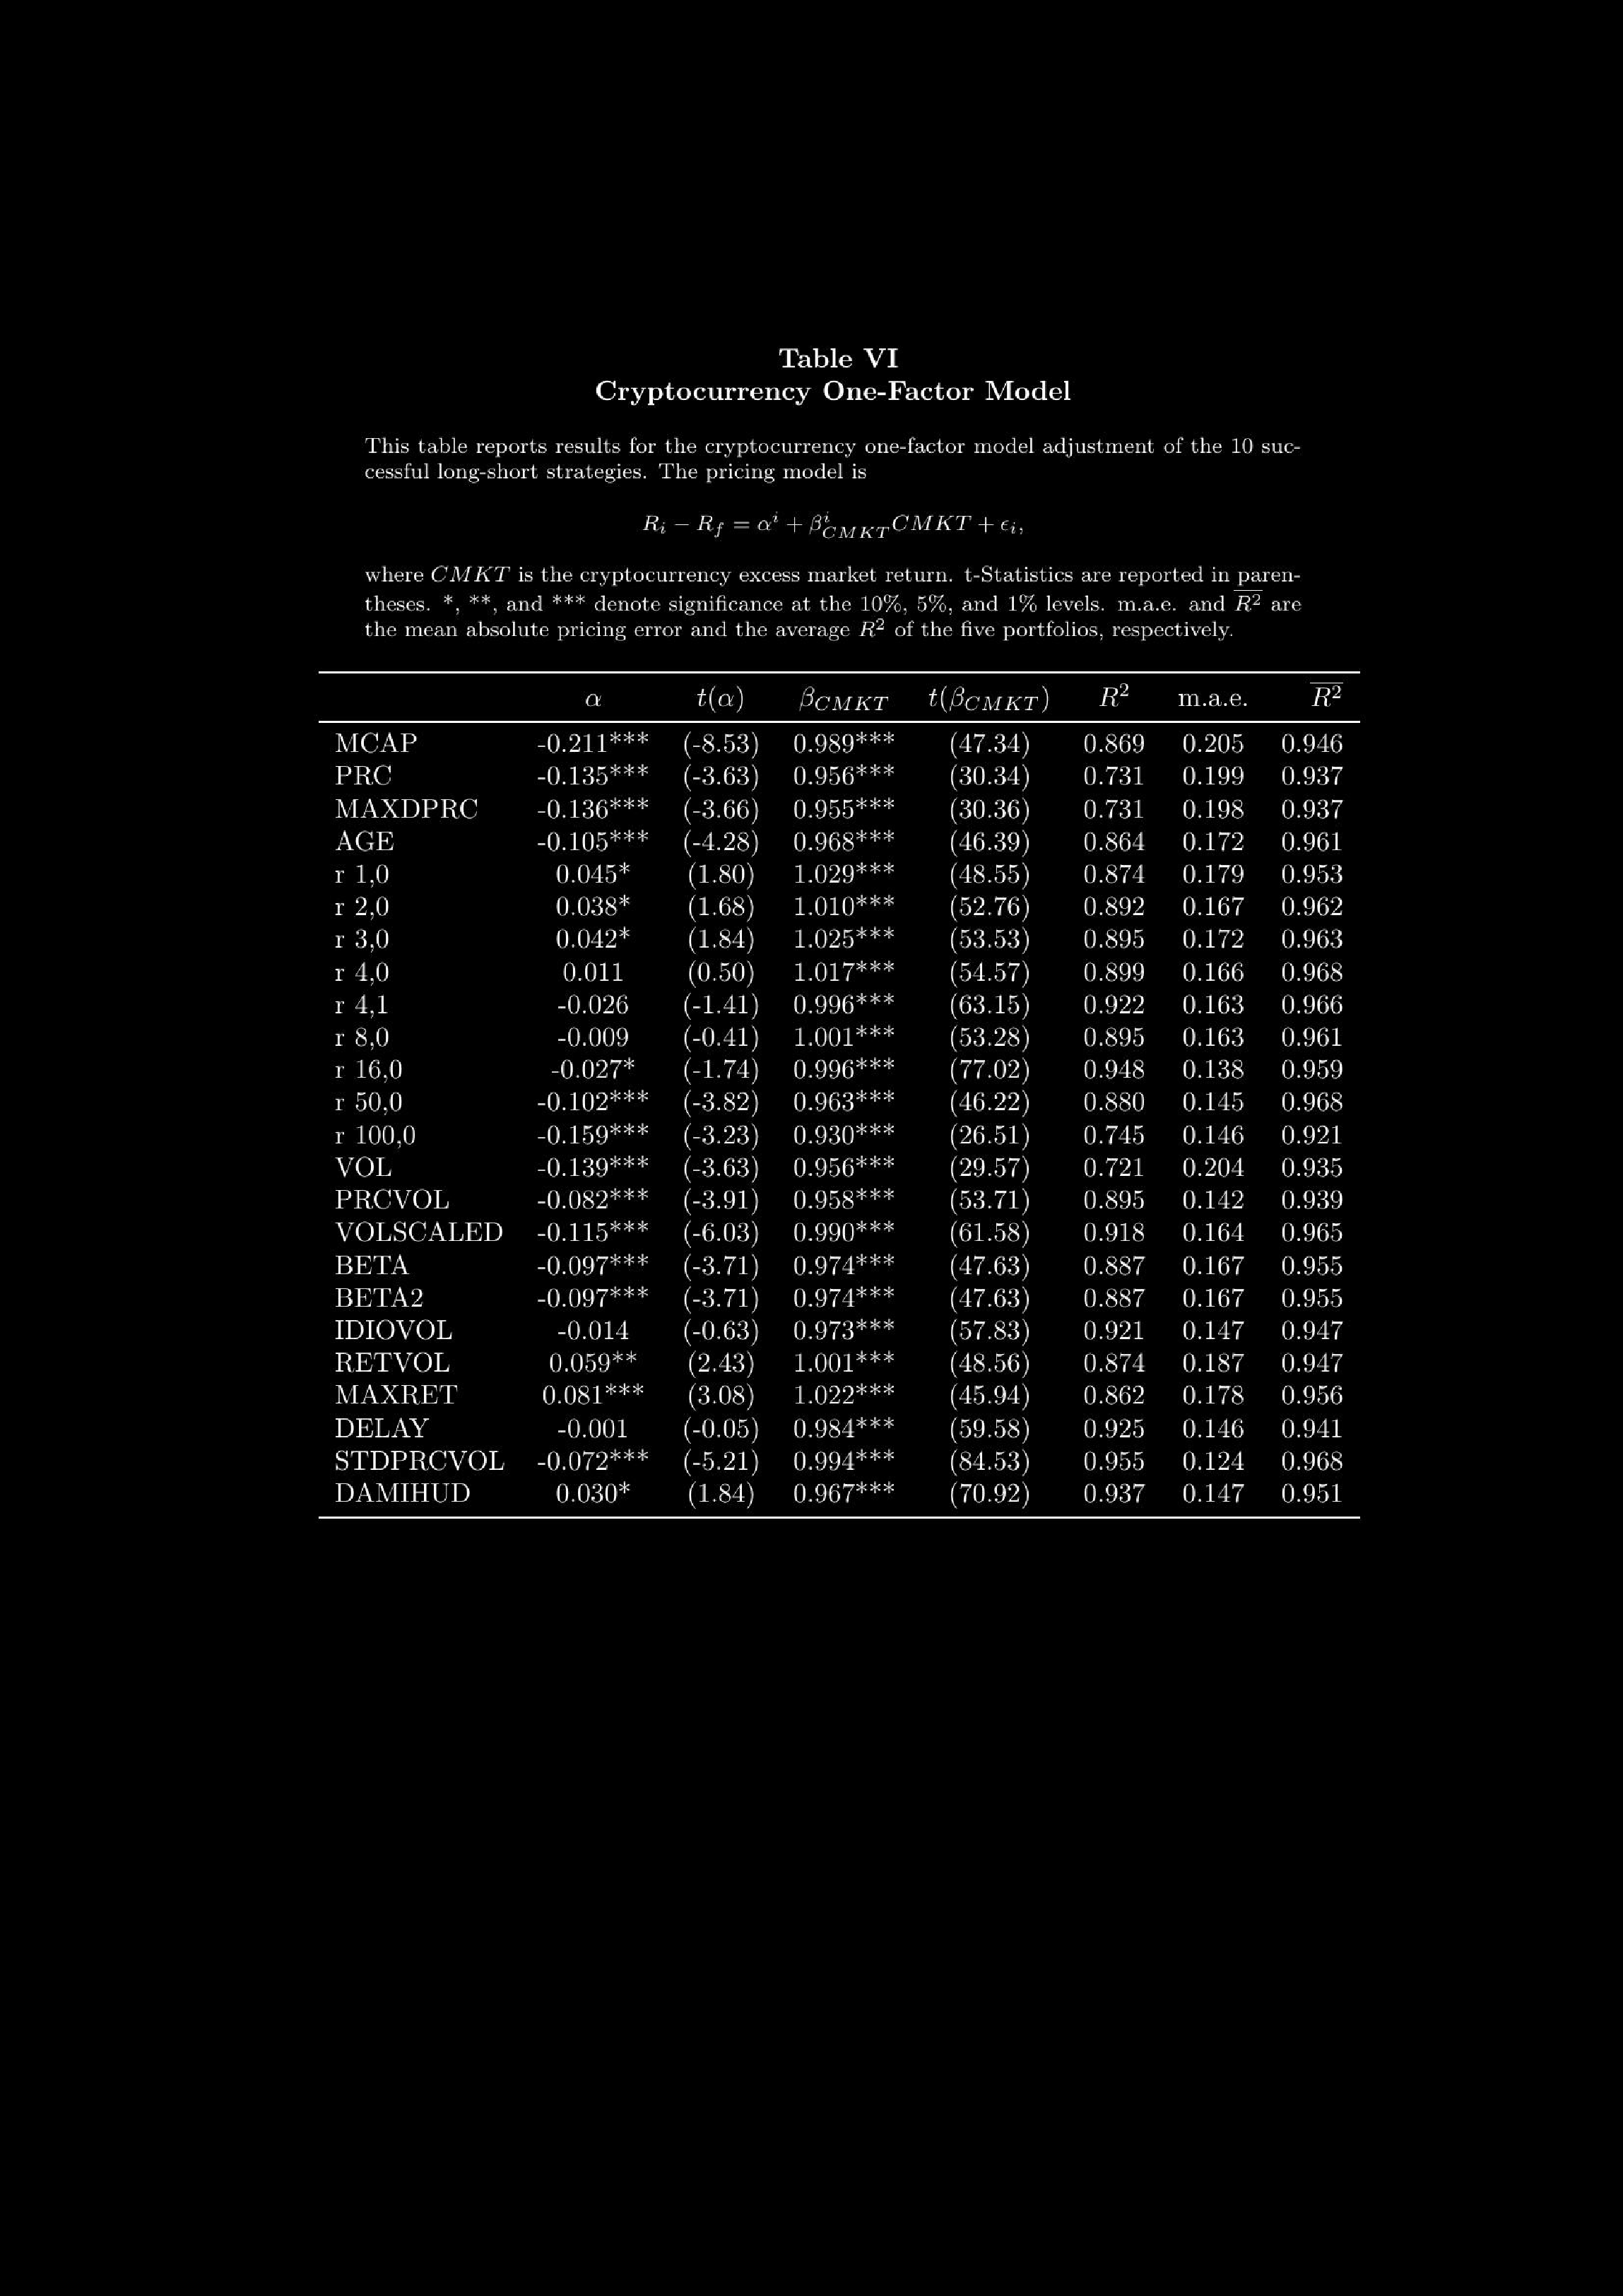

In [7]:
pd.options.mode.chained_assignment = None
if disable_warnings:
    warnings.simplefilter("ignore")

# here, we render the table for the one-factor model
if not os.path.exists(directory + "/one_factor_model_data.csv"):

    # quintile data to construct the dependent variables
    quintile_data1 = pd.read_csv(directory + "/quintile_size_data.csv", index_col=["date"])
    quintile_data2 = pd.read_csv(directory + "/quintile_momentum_data.csv", index_col=["date"])
    quintile_data3 = pd.read_csv(directory + "/quintile_volume_data.csv", index_col=["date"])
    quintile_data4 = pd.read_csv(directory + "/quintile_volatility_data.csv", index_col=["date"])
    quintile_data = pd.concat([quintile_data1, quintile_data2, quintile_data3, quintile_data4], axis=1)
    quintile_data.index = pd.to_datetime(quintile_data.index)

    all_vars = ["log_market_cap", "log_price", "log_max_price", "age", "one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum", "log_average_volume", "price_times_volume", "price_times_volume_scaled_market_cap", "beta", "standard_deviation", "max_return", "log_volume_std", "abs_return_per_volume", "beta_squared", "residual_std", "r_squared_difference"]
    alphas = []
    t_alphas = []
    p_alphas = []
    betas = []
    t_betas = []
    p_betas = []
    r_squareds = []
    mean_absolute_errors = []
    average_r_squareds = []

    # create a single dataframe to consistently remove the rows with missing values
    df = pd.concat([quintile_data, market_weekly_returns], axis=1)
    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.index = pd.to_datetime(df.index)
    
    for var in all_vars:
        # the long-short strategy in excess of the risk-free rate is the dependent variable
        sub_df = df[[var + "_long_short", "DGS1MO", "market_excess_return"]].copy().dropna()
        model = sm.OLS(sub_df[var + "_long_short"] - sub_df["DGS1MO"], sm.add_constant(sub_df["market_excess_return"])).fit()
        alphas.append(model.params[0])
        t_alphas.append(model.tvalues[0])
        p_alphas.append(model.pvalues[0])
        betas.append(model.params[1])
        t_betas.append(model.tvalues[1])
        p_betas.append(model.pvalues[1])
        r_squareds.append(model.rsquared)
        # predict using the fitted model
        pred = model.predict(sm.add_constant(sub_df["market_excess_return"]))
        # calculating the MAE
        MAE = np.mean(np.abs(sub_df[var + "_long_short"] - sub_df["DGS1MO"] - pred))
        mean_absolute_errors.append(MAE)
        # computing the average R-squared for the 5 quintiles excess return series as dependent variables
        sum_r_squared = 0
        for quintile in ["q1", "q2", "q3", "q4", "q5"]:
            sub_df = df[[var + "_" + quintile, "market_excess_return"]].copy().dropna()
            model = sm.OLS(sub_df[var + "_" + quintile], sm.add_constant(sub_df["market_excess_return"])).fit()
            sum_r_squared += model.rsquared
        average_r_squareds.append(sum_r_squared / 5)
    
    df = pd.DataFrame({"ls_strategy": all_vars, "alpha": alphas, "t_alpha": t_alphas, "p_alpha": p_alphas, "beta": betas, "t_beta": t_betas, "p_beta": p_betas, "r_squared": r_squareds, "mean_absolute_error": mean_absolute_errors, "average_r_squared": average_r_squareds})
    # downloading the data
    df.to_csv(directory + "/one_factor_model_data.csv")
else:
    print("The data for the excess long-short strategies for the different volatility strategies has already been computed.")
    df = pd.read_csv(directory + "/one_factor_model_data.csv")
    df.index = pd.to_datetime(df.index)

all_vars = ["log_market_cap", "log_price", "log_max_price", "age", "one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum", "log_average_volume", "price_times_volume", "price_times_volume_scaled_market_cap", "beta", "standard_deviation", "max_return", "log_volume_std", "abs_return_per_volume", "beta_squared", "residual_std", "r_squared_difference"]
helpers.render_factor_models_statistics(df, "latex_templates/one_factor_model_statistics.tex", all_vars, invert)

pdf_path = os.getcwd() + "/cover.pdf"
img = Image(filename=pdf_path, resolution=100)
img

The data for the excess long-short strategies for the different volatility strategies has already been computed.


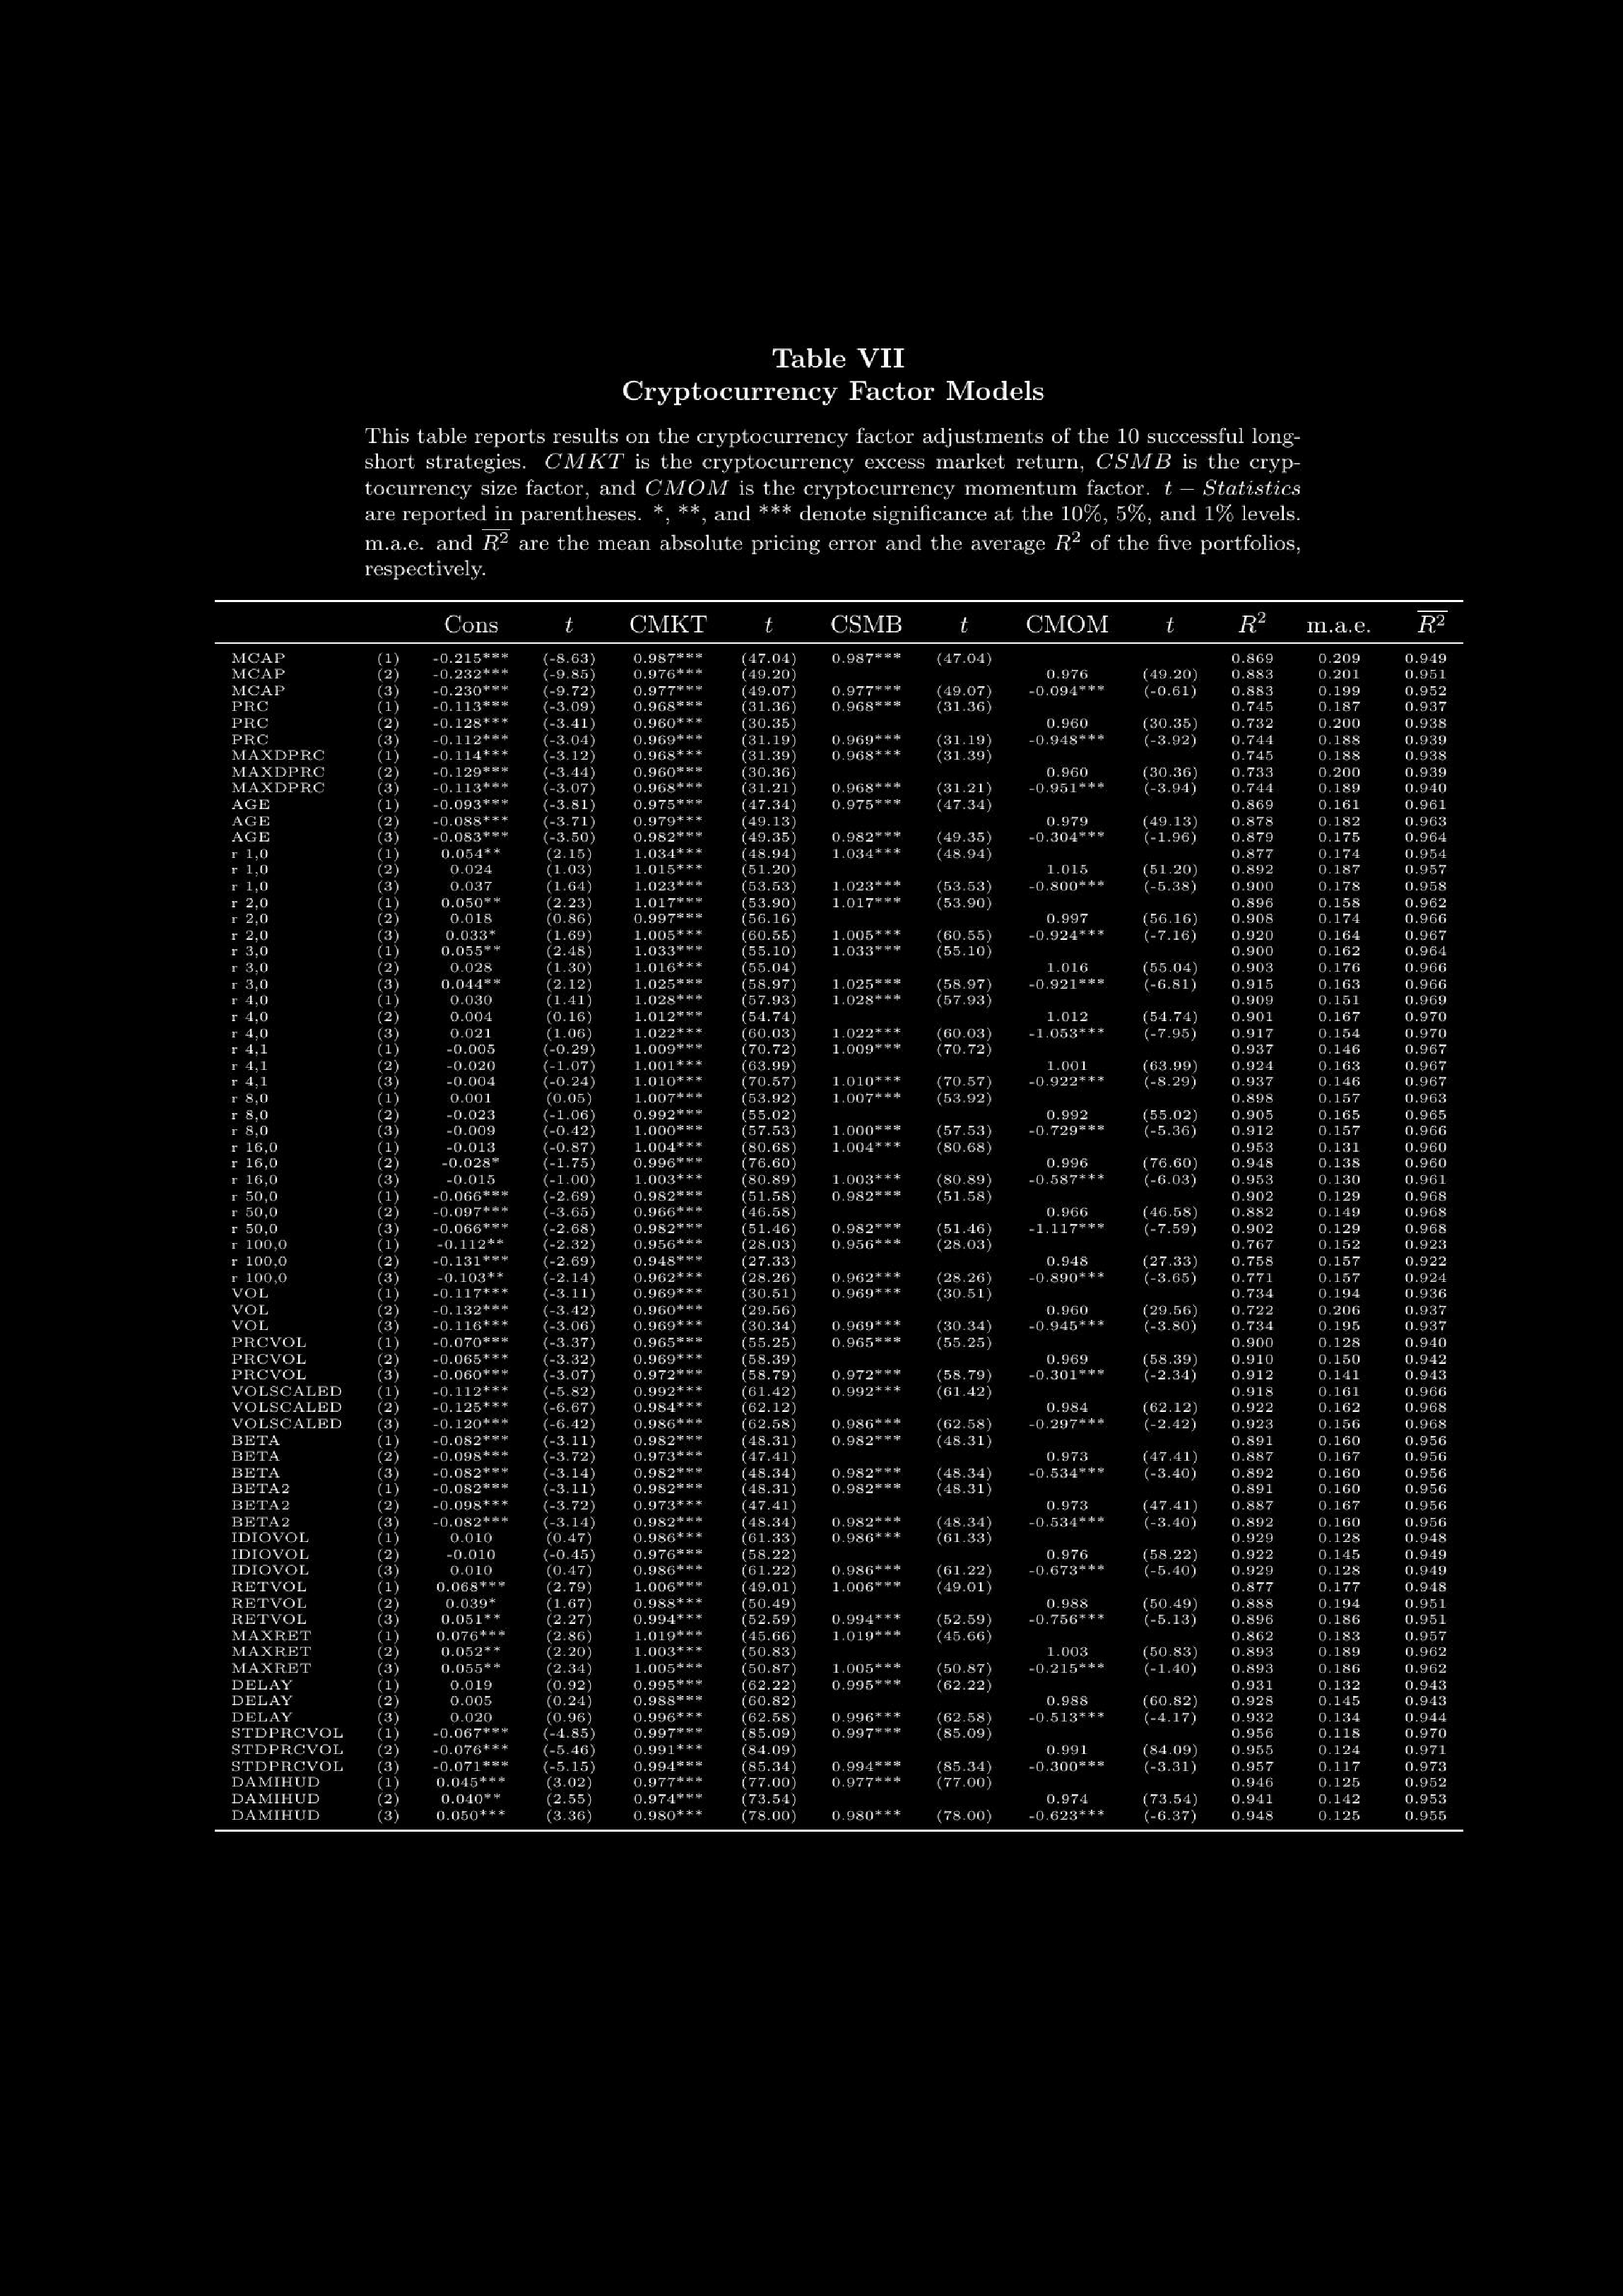

In [8]:
pd.options.mode.chained_assignment = None
if disable_warnings:
    warnings.simplefilter("ignore")

# here, we render the table for the multi-factor models
# we can use the tertile function for the past returns
tertiles_market_cap = helpers.tertile_returns(weekly_returns_data, "market_cap")
# computing the long-short strategy
market_weekly_returns["small_minus_big"] = np.where(tertiles_market_cap["market_cap_q1"].isna(), tertiles_market_cap["market_cap_q3"], tertiles_market_cap["market_cap_q3"] - tertiles_market_cap["market_cap_q1"])

# first dividing by market_cap and then by three_week_momentum
q1_return_df, q2_return_df = helpers.two_times_three_returns(weekly_returns_data)
market_weekly_returns["momentum"] = 0.5 * (q1_return_df["three_week_momentum_q3"] - q2_return_df["three_week_momentum_q3"]) + 0.5 * (q1_return_df["three_week_momentum_q1"] - q2_return_df["three_week_momentum_q1"])

if not os.path.exists(directory + "/multi_factor_models_data.csv"):

    # quintile data to construct the dependent variables
    quintile_data1 = pd.read_csv(directory + "/quintile_size_data.csv", index_col=["date"])
    quintile_data2 = pd.read_csv(directory + "/quintile_momentum_data.csv", index_col=["date"])
    quintile_data3 = pd.read_csv(directory + "/quintile_volume_data.csv", index_col=["date"])
    quintile_data4 = pd.read_csv(directory + "/quintile_volatility_data.csv", index_col=["date"])
    quintile_data = pd.concat([quintile_data1, quintile_data2, quintile_data3, quintile_data4], axis=1)
    quintile_data.index = pd.to_datetime(quintile_data.index)

    all_vars = ["log_market_cap", "log_price", "log_max_price", "age", "one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum", "log_average_volume", "price_times_volume", "price_times_volume_scaled_market_cap", "beta", "standard_deviation", "max_return", "log_volume_std", "abs_return_per_volume", "beta_squared", "residual_std", "r_squared_difference"]

    models = []
    variables = []
    alphas = []
    t_alphas = []
    p_alphas = []
    betas_market_excess_return = []
    t_betas_market_excess_return = []
    p_betas_market_excess_return = []
    betas_small_minus_big = []
    t_betas_small_minus_big = []
    p_betas_small_minus_big = []
    betas_momentum = []
    t_betas_momentum = []
    p_betas_momentum = []
    r_squareds = []
    mean_absolute_errors = []
    average_r_squareds = []

    # create one single dataframe to consistently remove the rows with missing values
    df = pd.concat([quintile_data, market_weekly_returns], axis=1)
    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    df.index = pd.to_datetime(df.index)
    
    for var in all_vars:
        sub_df1 = df[[var + "_long_short", "DGS1MO", "market_excess_return", "small_minus_big"]].copy().dropna()
        sub_df2 = df[[var + "_long_short", "DGS1MO", "market_excess_return", "momentum"]].copy().dropna()
        sub_df3 = df[[var + "_long_short", "DGS1MO", "market_excess_return", "small_minus_big", "momentum"]].copy().dropna()
        # the long-short strategy in excess of the risk-free rate is the dependent variable
        # now we have 2 or 3 explanatory variables, respectively
        models_dict = {}
        models_dict["model1"] = sm.OLS(sub_df1[var + "_long_short"] - sub_df1["DGS1MO"], sm.add_constant(sub_df1[["market_excess_return", "small_minus_big"]])).fit()
        models_dict["model2"] = sm.OLS(sub_df2[var + "_long_short"] - sub_df2["DGS1MO"], sm.add_constant(sub_df2[["market_excess_return", "momentum"]])).fit()
        models_dict["model3"] = sm.OLS(sub_df3[var + "_long_short"] - sub_df3["DGS1MO"], sm.add_constant(sub_df3[["market_excess_return", "small_minus_big", "momentum"]])).fit()

        for name in models_dict.keys():
            model = models_dict[name]
            
            models.append(name)
            variables.append(var)
            alphas.append(model.params[0])
            t_alphas.append(model.tvalues[0])
            p_alphas.append(model.pvalues[0])
            betas_market_excess_return.append(model.params[1])
            t_betas_market_excess_return.append(model.tvalues[1])
            p_betas_market_excess_return.append(model.pvalues[1])
            if name == "model1":
                betas_small_minus_big.append(model.params[1])
                t_betas_small_minus_big.append(model.tvalues[1])
                p_betas_small_minus_big.append(model.pvalues[1])
                betas_momentum.append(np.nan)
                t_betas_momentum.append(np.nan)
                p_betas_momentum.append(np.nan)
            elif name == "model2":
                betas_small_minus_big.append(np.nan)
                t_betas_small_minus_big.append(np.nan)
                p_betas_small_minus_big.append(np.nan)
                betas_momentum.append(model.params[1])
                t_betas_momentum.append(model.tvalues[1])
                p_betas_momentum.append(model.pvalues[1])
            elif name == "model3":
                betas_small_minus_big.append(model.params[1])
                t_betas_small_minus_big.append(model.tvalues[1])
                p_betas_small_minus_big.append(model.pvalues[1])
                betas_momentum.append(model.params[2])
                t_betas_momentum.append(model.tvalues[2])
                p_betas_momentum.append(model.pvalues[2])
            r_squareds.append(model.rsquared)
            # predict using the fitted model
            if name == "model1":
                pred = model.predict(sm.add_constant(sub_df1[["market_excess_return", "small_minus_big"]]))
                # calculate the MAE
                MAE = np.mean(np.abs(sub_df1[var + "_long_short"] - sub_df1["DGS1MO"] - pred))
            elif name == "model2":
                pred = model.predict(sm.add_constant(sub_df2[["market_excess_return", "momentum"]]))
                # calculate the MAE
                MAE = np.mean(np.abs(sub_df2[var + "_long_short"] - sub_df2["DGS1MO"] - pred))
            elif name == "model3":
                pred = model.predict(sm.add_constant(sub_df3[["market_excess_return", "small_minus_big", "momentum"]]))
                # calculate the MAE
                MAE = np.mean(np.abs(sub_df3[var + "_long_short"] - sub_df3["DGS1MO"] - pred))
            mean_absolute_errors.append(MAE)
            # computing the average R-squared for the 5 quintiles excess return series as dependent variables
            sum_r_squared = 0
            if name == "model1":
                for quintile in ["q1", "q2", "q3", "q4", "q5"]:
                    sub_df = df[[var + "_" + quintile, "market_excess_return", "small_minus_big"]].copy().dropna()
                    model = sm.OLS(sub_df[var + "_" + quintile], sm.add_constant(sub_df[["market_excess_return", "small_minus_big"]])).fit()
                    sum_r_squared += model.rsquared
            elif name == "model2":
                for quintile in ["q1", "q2", "q3", "q4", "q5"]:
                    sub_df = df[[var + "_" + quintile, "market_excess_return", "momentum"]].copy().dropna()
                    model = sm.OLS(sub_df[var + "_" + quintile], sm.add_constant(sub_df[["market_excess_return", "momentum"]])).fit()
                    sum_r_squared += model.rsquared
            elif name == "model3":
                for quintile in ["q1", "q2", "q3", "q4", "q5"]:
                    sub_df = df[[var + "_" + quintile, "market_excess_return", "small_minus_big", "momentum"]].copy().dropna()
                    model = sm.OLS(sub_df[var + "_" + quintile], sm.add_constant(sub_df[["market_excess_return", "small_minus_big", "momentum"]])).fit()
                    sum_r_squared += model.rsquared
            average_r_squareds.append(sum_r_squared / 5)

    df = pd.DataFrame({"model": models, "ls_strategy": variables, "alpha": alphas, "t_alpha": t_alphas, "p_alpha": p_alphas, "beta_market_excess_return": betas_market_excess_return, "t_beta_market_excess_return": t_betas_market_excess_return, "p_beta_market_excess_return": p_betas_market_excess_return, "beta_small_minus_big": betas_small_minus_big, "t_beta_small_minus_big": t_betas_small_minus_big, "p_beta_small_minus_big": p_betas_small_minus_big, "beta_momentum": betas_momentum, "t_beta_momentum": t_betas_momentum, "p_beta_momentum": p_betas_momentum, "r_squared": r_squareds, "mean_absolute_error": mean_absolute_errors, "average_r_squared": average_r_squareds})
    # downloading the data
    df.to_csv(directory + "/multi_factor_models_data.csv")
else:
    print("The data for the excess long-short strategies for the different volatility strategies has already been computed.")
    df = pd.read_csv(directory + "/multi_factor_models_data.csv")
    df.index = pd.to_datetime(df.index)

all_vars = ["log_market_cap", "log_price", "log_max_price", "age", "one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum", "log_average_volume", "price_times_volume", "price_times_volume_scaled_market_cap", "beta", "standard_deviation", "max_return", "log_volume_std", "abs_return_per_volume", "beta_squared", "residual_std", "r_squared_difference"]
helpers.render_factor_models_statistics(df, "latex_templates/multi_factor_models_statistics.tex", all_vars, invert)

pdf_path = os.getcwd() + "/cover.pdf"
img = Image(filename=pdf_path, resolution=100)
img